# i. BUSINESS JOB DESCRIPTION


*   Our client is an Insurance Company that has provided health insurance to its customers. Now, they are analyzing the possibility of offering a new product in order to profit from cross selling: Vehicular Insurance.

*   An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

*   Cross selling is the practice that involves the selling of related products. In this case, it is a way of increasing both revenue and customer loyalty, thus improving a customer's lifetime value/retention.


# ii. THE CHALLENGE

*   We were hired as data scientists consultants, with goals to build a model that predicts whether our client's customer would also be interested in auto insurance.

*   With the solution, the company can then accordingly plan its communication strategy to reach out those customers thus optimizing its business model by only making contact with those customers who are most likely to make the purchase.

*   In order to understand our client's customers behaviours, we have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel), which will be used further for the construction of our Machine Larning Prediction model. This overall data was obtained upon a survey with about 380,000 customers, with response about their interest in joining a new auto insurance program.

# iii. BUSINESS QUESTIONS

*   What are the main insights on the most relevant attributes of relevants customers in purchasing vehicular insurance?

*   What percentage of customers are interested in purchasing vehicular insurance, given the constraint of making only 20,000 calls?






# 0.0 IMPORTS, FUNCTIONS AND CONNECTIONS

In [106]:
!pip install scikit-plot

In [107]:
!pip install optuna

## 0.1 PACKAGES AND LIBRARIES

In [108]:
import pandas       as pd
import numpy        as np
import psycopg2     as pg
import seaborn      as sns
import scikitplot   as skplt
import xgboost      as xgb
import lightgbm     as lgbm
import optuna
import pickle
import warnings
#import dotenv
import os

from matplotlib     import pyplot as plt
from collections    import Counter
from sqlalchemy     import create_engine

from sklearn.preprocessing      import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.model_selection    import train_test_split, StratifiedKFold, KFold
from sklearn.metrics            import log_loss


from optuna.integration import LightGBMPruningCallback

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Helper Function

In [109]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

def top_k_precision(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})

    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['ranking'] = df.index + 1
    df['precision_top_k'] = df['true'].cumsum()/df['ranking']

    if return_df:
        return df.loc[k, 'precision_top_k'], df
    else:
        return df.loc[k, 'precision_top_k']

def top_k_recall(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})

    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['ranking'] = df.index + 1
    df['recall_top_k'] = df['true'].cumsum()/df['true'].sum()

    if return_df:
        return df.loc[k, 'recall_top_k'], df

    else:
        return df.loc[k, 'recall_top_k']

def top_k_f1score(y_true, y_score, k=10):

    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)

    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

def ml_top_k_scores(model_name, y_true, y_score, k=10):

    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)
    f1 = top_k_f1score(y_true, y_score, k)

    return pd.DataFrame({'Precision_at_k': np.round(precision, 4),
                         'Recall_at_k': np.round(recall, 4),
                         'F1_at_k': np.round(f1, 4)},
                        index=[model_name])

def ml_cv(model_name, model, X, y):
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=32)

    precision_k = []
    recall_k = []
    F1_score_k = []
    for idx, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        #print(f'Fold k-{idx}')
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        yhat_model = model.predict_proba( X_test )

        precision = top_k_precision(y_test, yhat_model, 20000)
        recall = top_k_recall(y_test, yhat_model, 20000)
        F1_score = top_k_f1score(y_test, yhat_model, 20000)

        precision_k.append(precision)
        recall_k.append(recall)
        F1_score_k.append(F1_score)

    return pd.DataFrame({'Model Name': model_name,
                         'Precision@k': f"{round(np.mean(precision_k), 2)} +/- {round(np.std(precision_k), 5)}",
                         'Recall@k': f"{round(np.mean(recall_k), 2)} +/- {round(np.std(recall_k), 5)}",
                         'F1_score@k': f"{round(np.mean(F1_score_k), 2)} +/- {round(np.std(F1_score_k), 5)}"},
                         index = [0])

def objective(trial, X, y, k):
    '''
    Conventional optimization function
    signature for optuna
    '''

    params ={ 'boosting': trial.suggest_categorical('boosting', ['gbdt', 'rf', 'dart']),
              'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'max_depth': trial.suggest_int('max_depth', 3, 15, step=2),
              'num_leaves': trial.suggest_int('num_leaves', 8, 1000, step=20),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 10000, step=100),
              'min_gain_to_split': trial.suggest_int('min_gain_to_split', 0, 15, step=5),
              'lambda_l1': trial.suggest_int('lambda_l1', 10, 100, step=10),
              'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 0.95, step=0.1),
              'bagging_freq': trial.suggest_categorical('bagging_freq',[1]),
              'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1),
              'random_state': 32}

    cv = StratifiedKFold(n_splits = 4, shuffle=True, random_state=32)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective='binary', **params)
        model.fit(X_train,
                  y_train,
                  eval_set = [(X_test, y_test)],
                  eval_metric = 'auc' ,
                  early_stopping_rounds=100,
                  callbacks=[
                      LightGBMPruningCallback(trial, 'auc')
                  ])  #Add a pruning callback

        preds = model.predict_proba( X_test )

        ##Ranking the predictions by sorting
        #class_predict = pd.DataFrame(preds, columns=['negative_class_predict', 'positive_class_predict'])
        #class_predict['int_predict'] = class_predict['positive_class_predict'].apply(lambda x: 0 if (x < 0.3) else 1)
        #class_true = pd.DataFrame(y_test,columns=['response'])

        #unordered_predictions = pd.concat([X_test.reset_index(drop=True),
        #                                   class_predict, class_true.reset_index(drop=True)], axis=1)

        #ranked_prediction = unordered_predictions.sort_values('positive_class_predict', ascending=False)

        ##Conversion to boolean
        #threshold = 0
        #ranked_prediction[['int_predict', 'response']] = (ranked_prediction[['int_predict', 'response']] > threshold)

        cv_scores[idx] = top_k_recall(y_test, preds, 20000)

    return np.mean(cv_scores)

In [110]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Database Connections

### 0.3.1 Database load files (sqlalchemy and psycopg2)

* This section shows the connection and query procedures used for initial data gathering.
* The code is shown as commentary string for research purposes, as it was choosen to load the dataset .csv file locally for better speed on aplication.

In [111]:
#dotenv.load_dotenv(dotenv.find_dotenv())
#url_sql = os.getenv('url_sql')
#engine = create_engine(url_sql)

#host = os.getenv('PA004_HOST')
#port = os.getenv('PA004_PORT')
#dbname = os.getenv('PA004_DATABASE')
#username = os.getenv('PA004_USERNAME')
#password = os.getenv('PA004_PASSWORD')

#conn = pg.connect(host=host, port=port, dbname=dbname, user=username, password=password)

#cur = conn.cursor()

In [112]:
#sql_query = '''
#SELECT u.id, u.age, u.region_code, u.policy_sales_channel,
#       i.previously_insured, i.annual_premium, i.vintage, i.response,
#       v.driving_license, v.vehicle_age, v.vehicle_damage
#       FROM pa004.users u LEFT JOIN pa004.insurance i ON (u.id = i.id)
#                          LEFT JOIN pa004.vehicle v  ON (u.id = v.id)
#                          '''
#cur.execute(sql_query)
#df_raw = pd.read_sql_query(sql_query, con=engine)

#cur.close()
#conn.close()

### 0.3.2 Database load files (Pandas)

In [113]:
df_raw = pd.read_csv('datasets/insurance_data.csv')

In [114]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.0,152.0,0,23367.0,249,0,1,< 1 Year,Yes
1,13,Female,41,15.0,14.0,1,31409.0,221,0,1,1-2 Year,No
2,18,Female,25,35.0,152.0,1,46622.0,299,0,1,< 1 Year,No
3,31,Female,26,8.0,160.0,0,2630.0,136,0,1,< 1 Year,No
4,39,Male,45,8.0,124.0,0,42297.0,264,0,1,1-2 Year,Yes


# 1.0 DATA DESCRIPTION

In [115]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [116]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Types

### 1.2.1 Columns Description


*   Id: Unique ID for the customer.
*   Gender: Gender of the customer.
*   Age: Age of the customer.
*   Driving License: 0, customer does not have DL; 1, customer already has DL.
*   Region Code: Unique code for the region of the customer.
*   Previously Insured: 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance.
*   Vehicle Age: Age of the vehicle.
*   Vehicle Damage: 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past.
*   Anual Premium: The amount customer needs to pay as premium in the year.
*   Policy sales channel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
*   Vintage: Number of Days, customer has been associated with the company.
*   Response: 1, customer is interested; 0, customer is not interested.

### 1.2.2 Data Types Formating

In [117]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

In [118]:
df1['region_code'] = df1['region_code'].astype(int64)

df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int64)

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

## 1.3 Check NA

In [119]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

* no nan values to be filled!



## 1.4 Numerical Data Description

In [120]:
# Data Selection
df1_num = df1.select_dtypes(include=['int64', 'float64'])

#Central Tendency
ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(df1_num.apply(min)).T
d2 = pd.DataFrame(df1_num.apply(max)).T
d3 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1_num.apply(np.std)).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

df_descript = pd.concat([d1, d2, d3, ct1, ct2, d4, d5, d6]).T
df_descript.columns = ['min','max', 'range', 'average', 'median', 'std', 'skew', 'kurtosis']
df_descript

,min,max,range,average,median,std,skew,kurtosis
id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630




*   The average customer age is 39, with its maximum value as 85. Its distribution presents a right skew. (Not a Normal distribution)
*   The region code has negative skew, also noting that there is **not a normal distribution** upon this feature.
*   The mean value for 'previously_insured' is 0.46. Given that this is a binary feature, we can assume our dataset being balanced on this regard.
*   Similar conclusion can be taken to 'vehicle_damage' (mean value of 0,50)
*   On the other hand, the vast majority of the dataset has active driver license (mean value of 0.99).
*   The Range on for 'annual_premium' values is $537535,00. this indicates that there's a great difference on the ammount of price some users pay.
*   The maximum number of days to be with the company is 299 days and 10 days is the minimum.
*   The mean value for our 'response' variable is 0.12, which indicates an unbalaced dataset for clients we want to determine (the ones interested in acquiring vehicular insurance).


## 1.5 Categorical Data Description

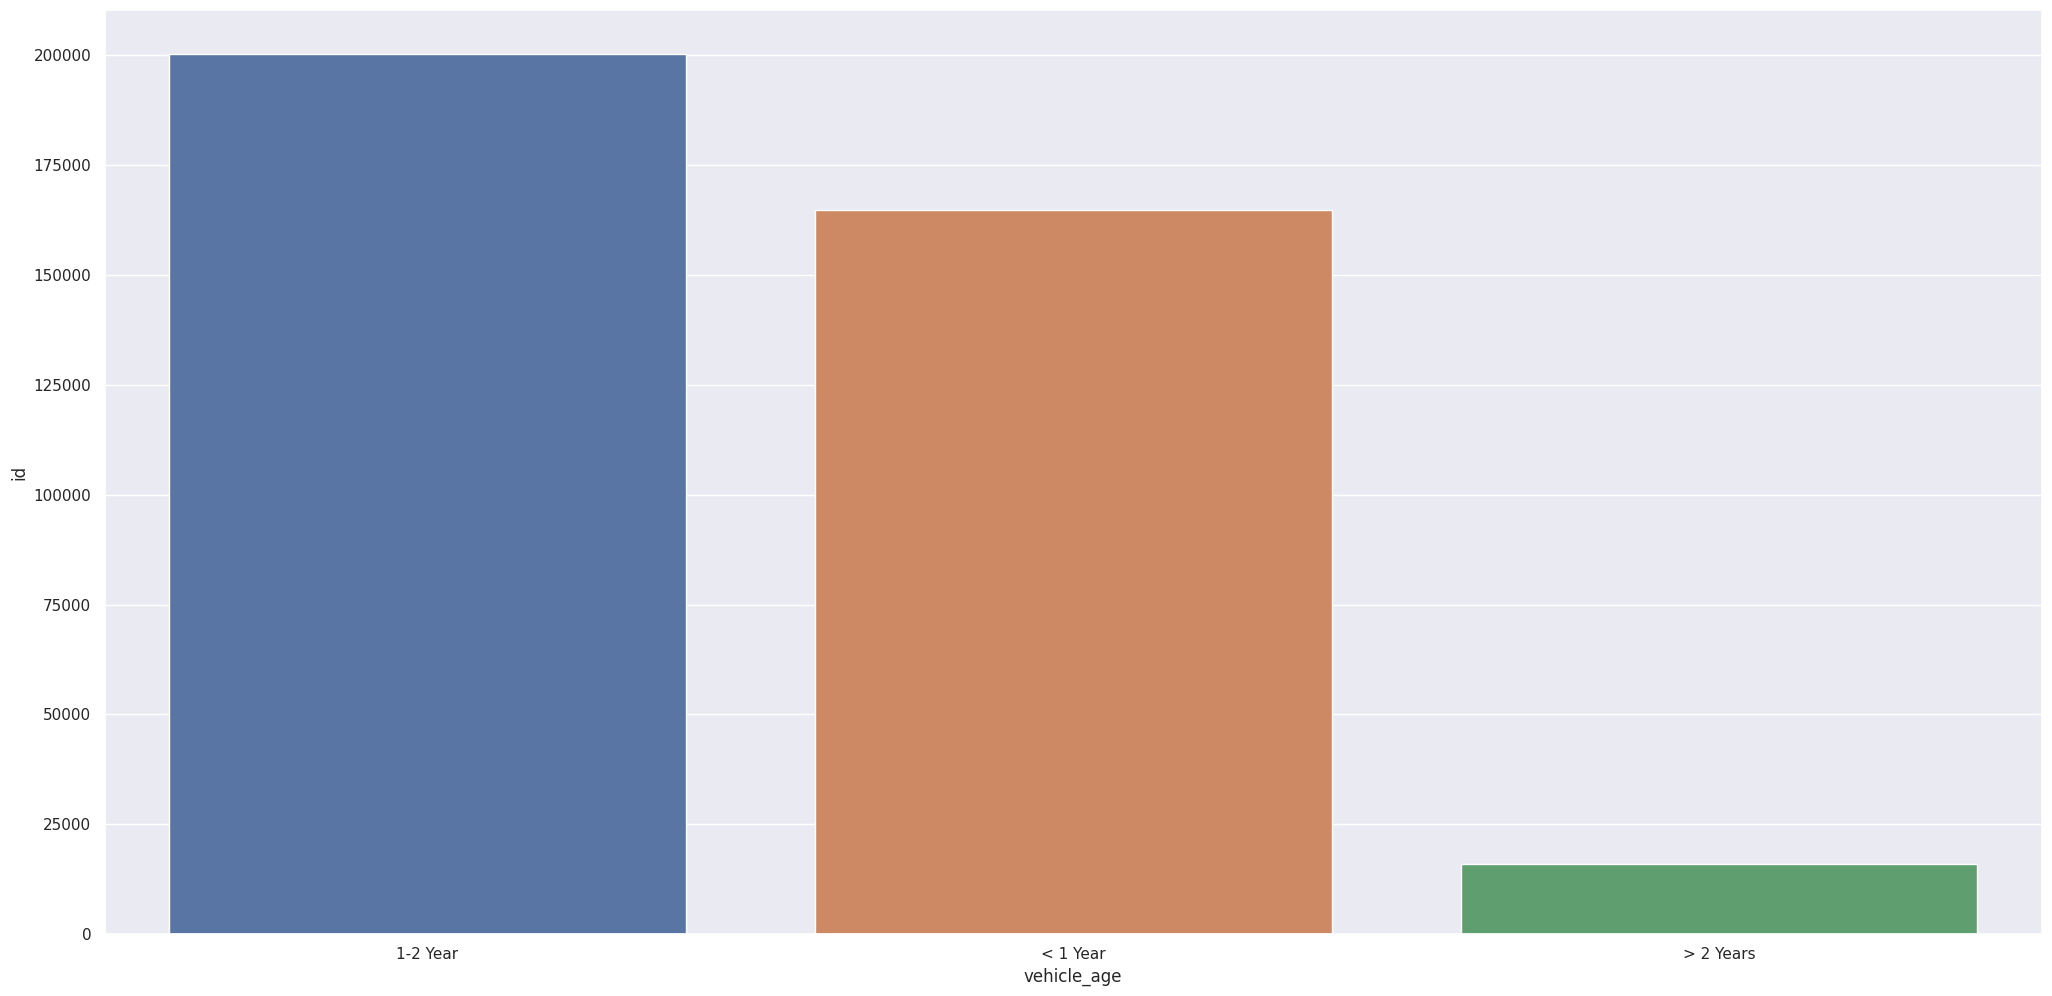

In [121]:
df_cat = df1[['vehicle_age', 'id']].groupby('vehicle_age').count().reset_index()

sns.barplot(data=df_cat, x='vehicle_age', y='id');



*   The most common vehicle age happens between the 1-2 year range.



# 2.0 HYPOTHESIS TEST

In [122]:
df2 = df1.copy()
reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'response']

df2 = df2.reindex(columns=reorder_columns)

## 2.1 Hypothesis Mindmap

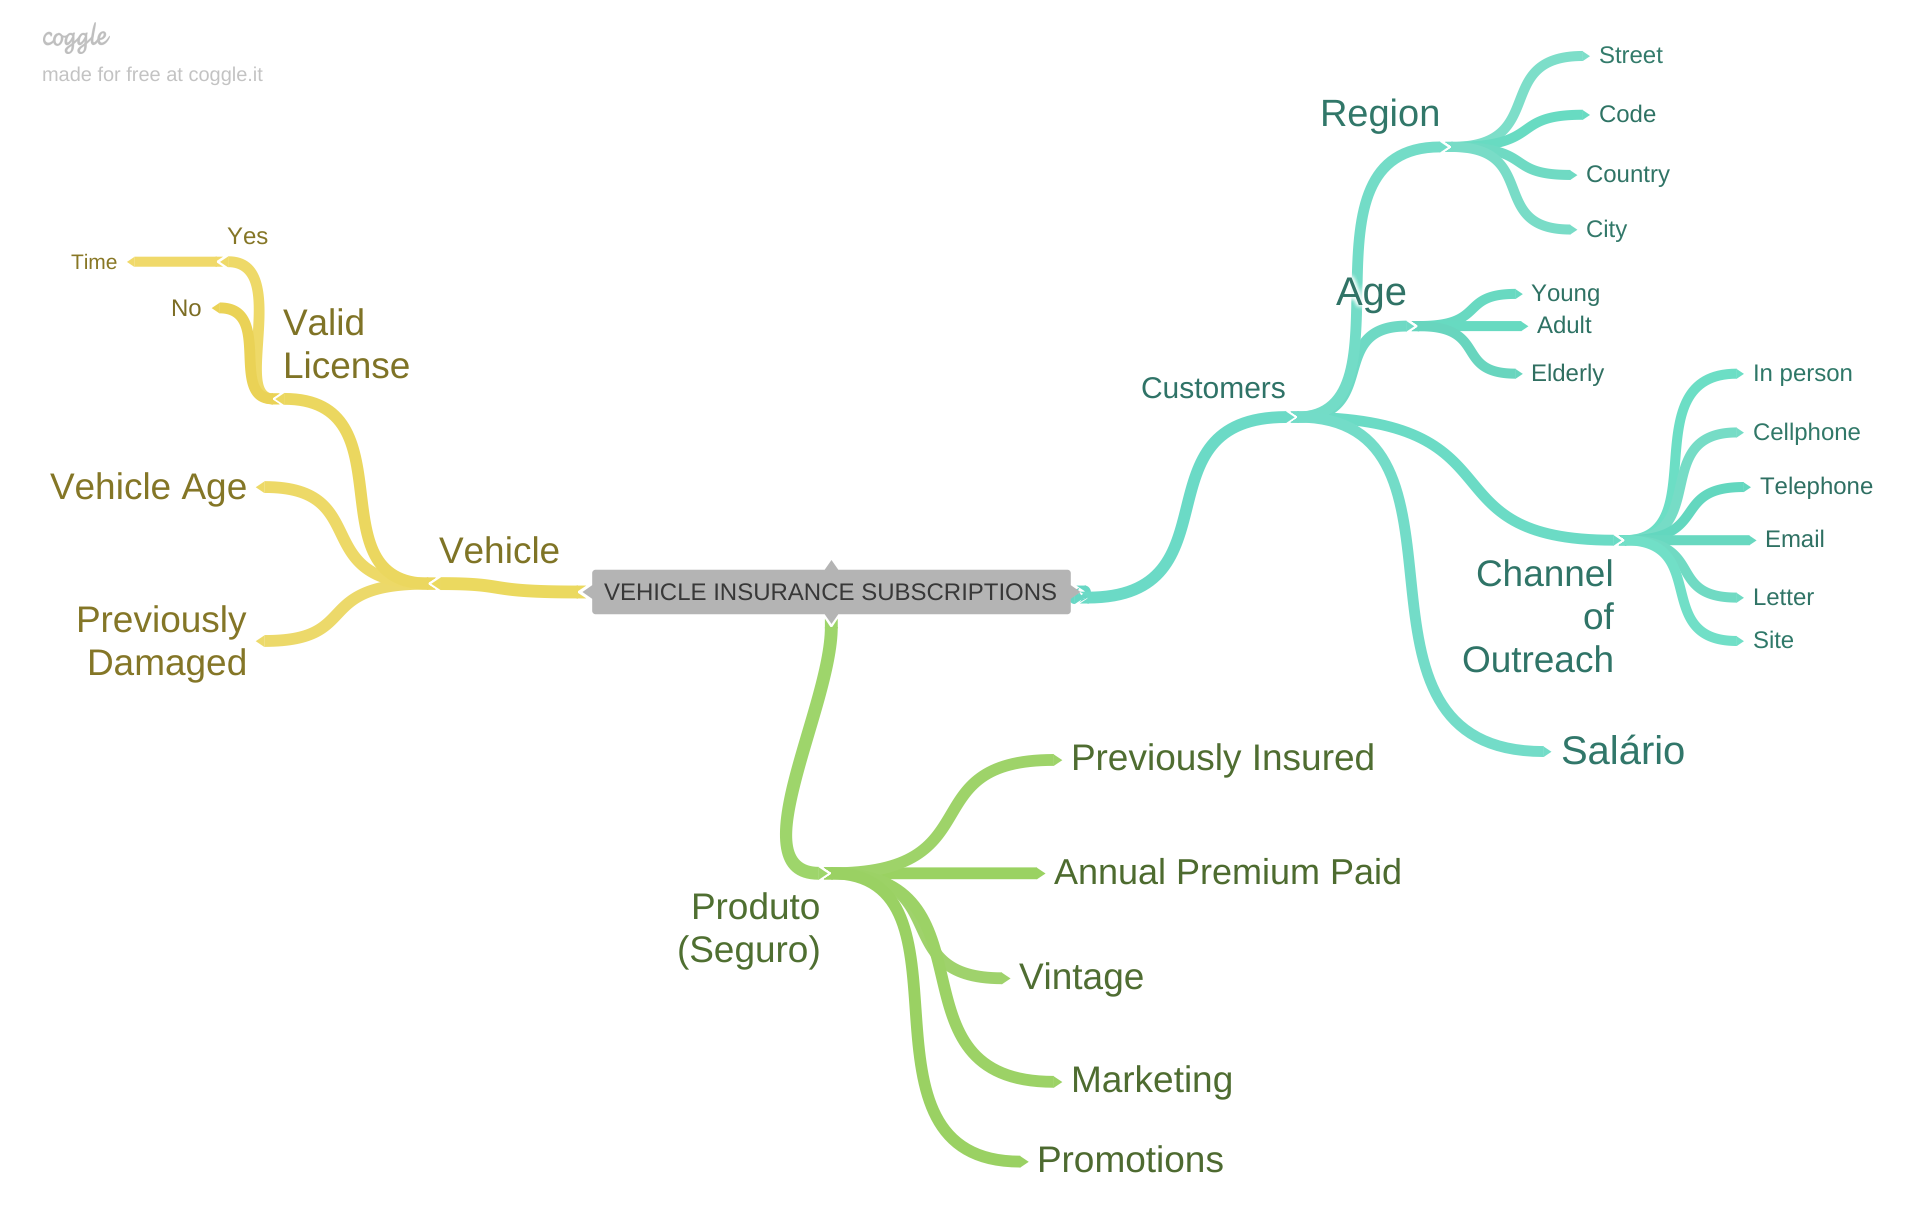

In [123]:
Image('img/MindMapHypothesis.png')

## 2.2 Hypothesis Creation


### 2.2.1 Customer Hypothesis

1. Older clients have are 10% more likely to acquire vehicular insurance.
2. Clients with higher salaries are 10% more likely to acquire vehicle insurance..
3. The closer to a urban center (region code),the higher the propensity to acquire a vehicle insurance

    *Are there any regions with higher incidence of security plans signed?

### 2.2.2 Product Hypothesis

1. Clients who already has a vehicle insurance are 10% less likely to aquire a new insurance plan.
2. Clients with higher annual premium paid are 10% less likely to acquire a vehicular insurance
3. Older clients on the database (Higher vintage count) are 10% more likely to acquire a vehicular insurance.
4. Clients who were exposed to marketing campaigns are 10% more likely to acquired vehicular insurance on cross sell.
5. Clients who are exposed to cross selling special deals are 10% more likely to acquire vehicle insurance.


### 2.2.3 Vehicular Hypothesis

1. Clients with valid drivers license are 10% more likely to acquire a new vehicular insurance.
2. Clients with older vehicles are 10% more likely to acquire a vehicular insurance.
3. Clients whose cehicles were already damaged are 10% more likely to acquire a vehicle insurance.

## 2.3 Selected Hypothesis

1. Older clients have are 10% more likely to acquire vehicular insurance.

2. Clients who already has a vehicle insurance are 10% less likely to aquire a new insurance plan.
3. Clients with higher annual premium paid are 10% less likely to acquire a vehicular insurance
4. Older clients on the database (Higher vintage count) are 10% more likely to acquire a vehicular insurance.

5. Clients with valid drivers license are 10% more likely to acquire a new vehicular insurance.
6. Clients with older vehicles are 10% more likely to acquire a vehicular insurance.
7. Clients whose cehicles were already damaged are 10% more likely to acquire a vehicle insurance.

8. Clients of a particular region are 10% more likely to acquire vehicular insurance.

In [124]:
df2.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,23,11,152,0,23367.0,249,1,< 1 Year,1,0
1,13,41,15,14,1,31409.0,221,1,1-2 Year,0,0
2,18,25,35,152,1,46622.0,299,1,< 1 Year,0,0
3,31,26,8,160,0,2630.0,136,1,< 1 Year,0,0
4,39,45,8,124,0,42297.0,264,1,1-2 Year,1,0


# 3.0 Exploratory Data Analysis & Feature Engineering

In [125]:
df3 = df2.copy()

## 3.1 Univariative Analysis

### 3.1.1 Numerical Variables

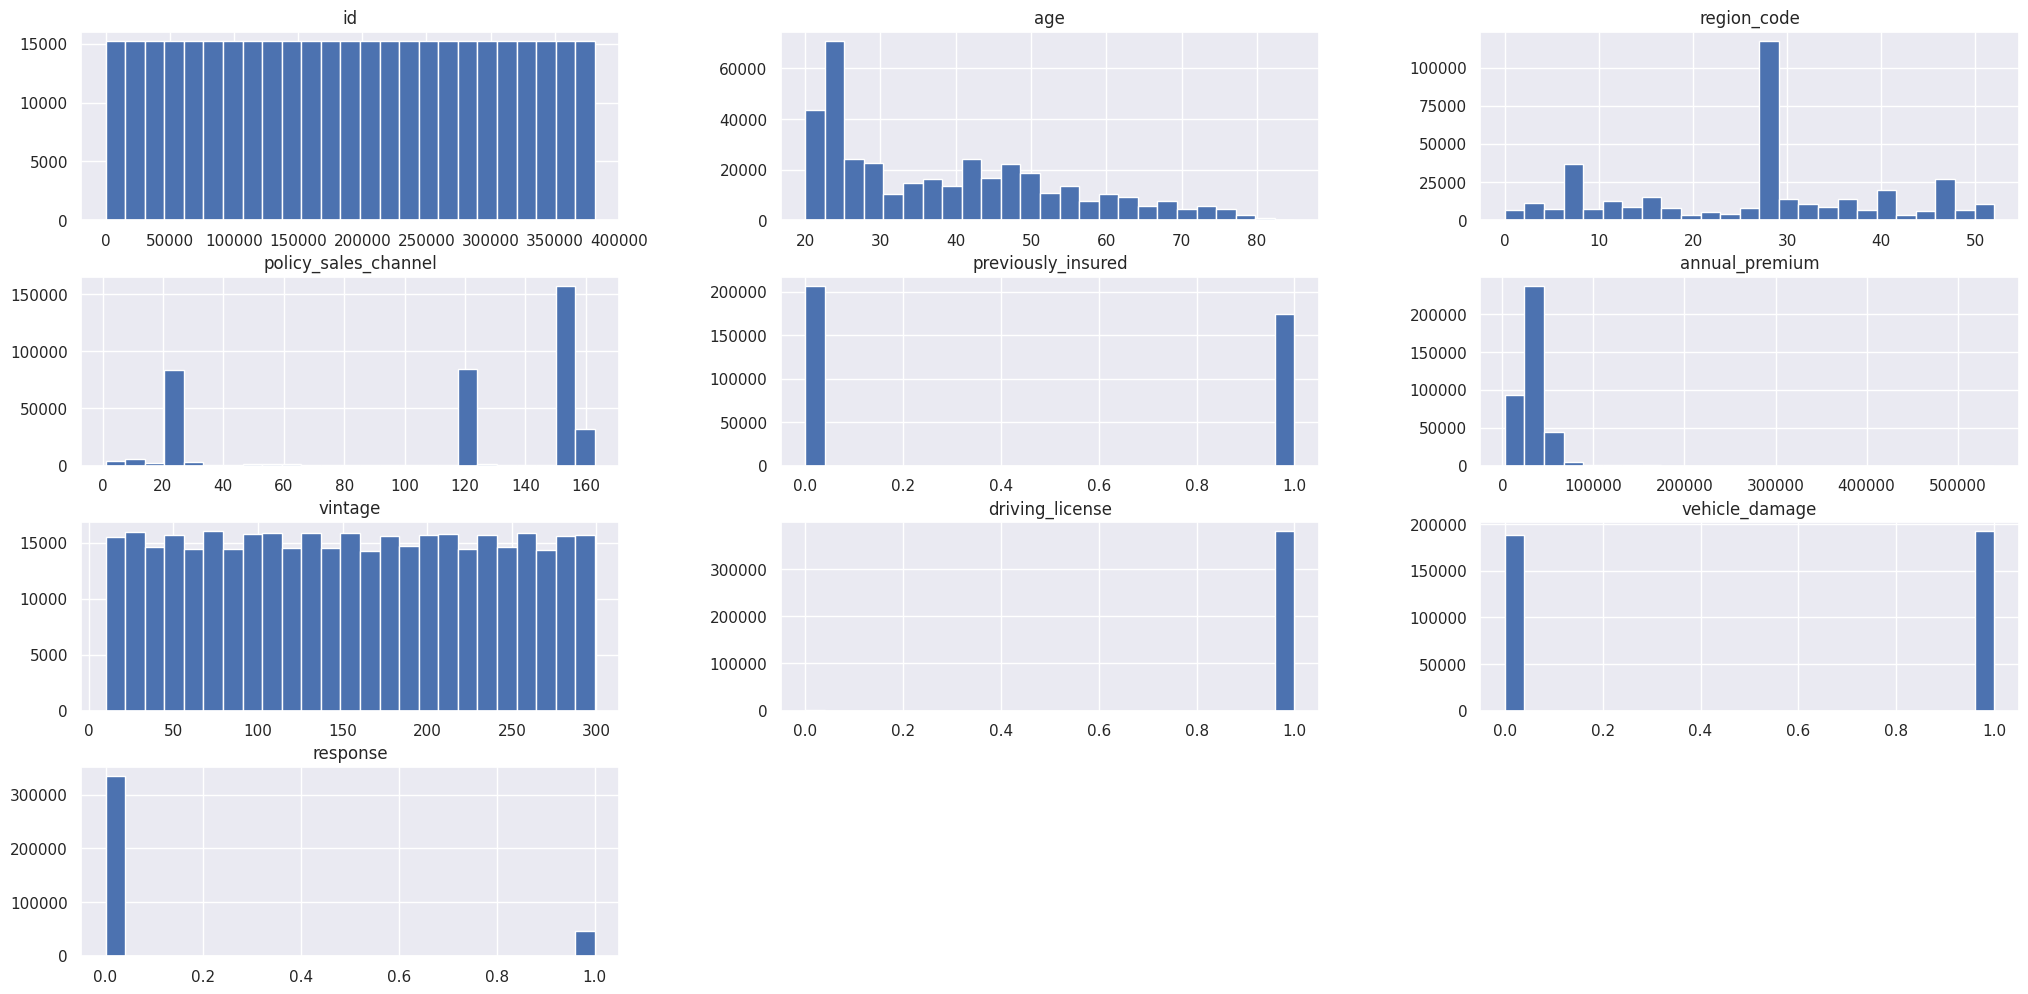

In [126]:
df3_num = df3.select_dtypes(include=['int64', 'float64'])

df3_num.hist(bins=25);



*   Note how unbalaced the dataset is for binary variables 'driving_license', and more importantly, the 'response' variable (which is our class variable).
*   No feature presents a normal distribution. Closest to that is the 'age' variable, which has a light right skew.



### 3.1.2 Categorical Variable

In [127]:
df3['vehicle_age'].drop_duplicates()

0      < 1 Year
1      1-2 Year
27    > 2 Years
Name: vehicle_age, dtype: object

# 3.2 Bivariative Analysis

### 3.2.1 Exploratory Data Analysis (EDA)

### H.1 Older clients have are 10% more likely to acquire vehicular insurance.
**True** -> There is a higher concentration of clients within the 40~50 year range that show interest in acquiring vehicular insurance.

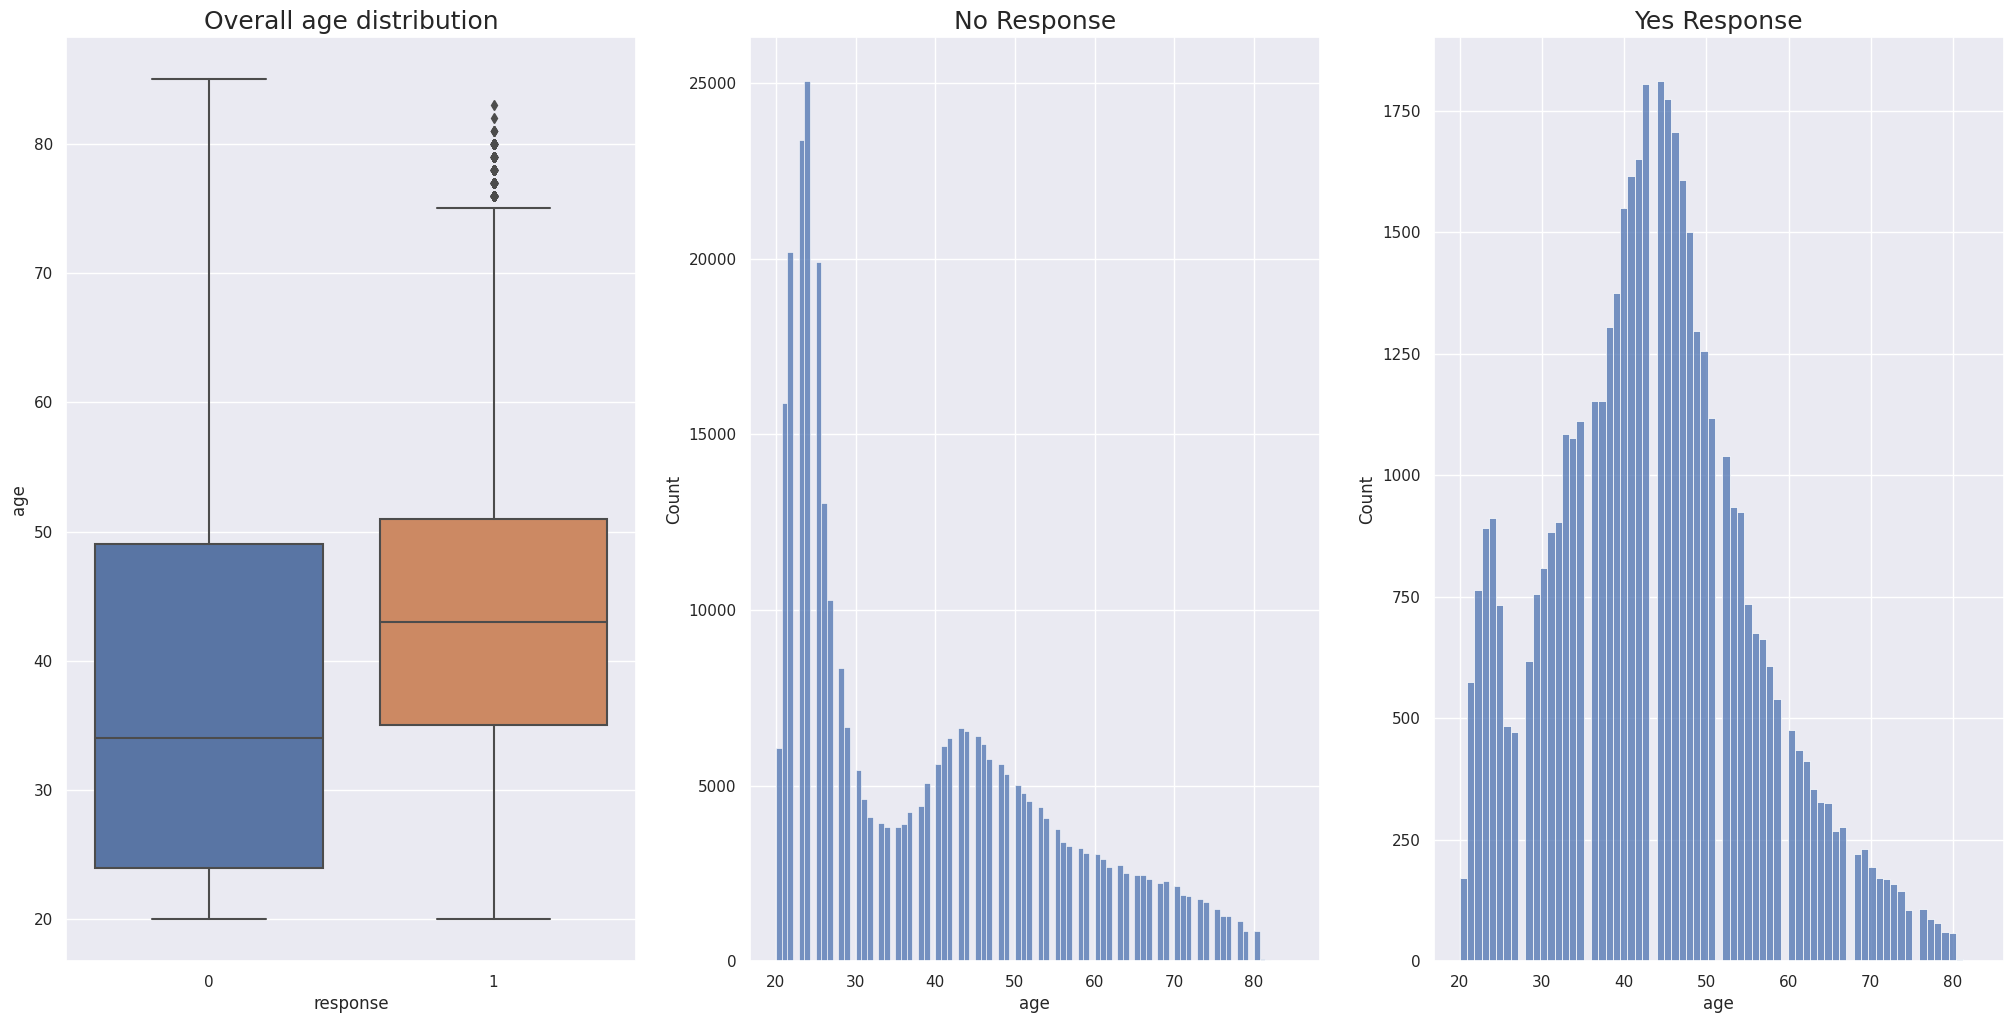

In [128]:
plt.subplot(1,3,1)
plt.title ('Overall age distribution', fontsize=18)
sns.boxplot(df3, x='response', y='age');

plt.subplot(1,3,2)
plt.title('No Response',fontsize=18)
aux = df3.loc[df3['response'] == 0, :]
sns.histplot(aux, x='age');

plt.subplot(1,3,3)
plt.title('Yes Response', fontsize=18)
aux = df3.loc[df3['response'] == 1, :]
sns.histplot(aux, x='age');

### H.2 Clients who already have a vehicle insurance are 10% less likely to aquire a new insurance plan.

**True** -> CAUTION: The severe unbalanced proportion shown on the contigency table between 'previously_insured' and 'response' variable can be a sign of data leakage; hence it will not be adequate for use upon building our Machine Learning model.

In [129]:
aux2 = pd.crosstab(df3['previously_insured'], df3['response'])
aux2 = aux2.apply(lambda x: x/x.sum(), axis=1)
aux2

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### H.3 Clients with higher annual premium paid are 10% less likely to acquire a vehicular insurance.
**False** -> Both distributions point to similar mean and median values. (Similiar central tendency metrics)

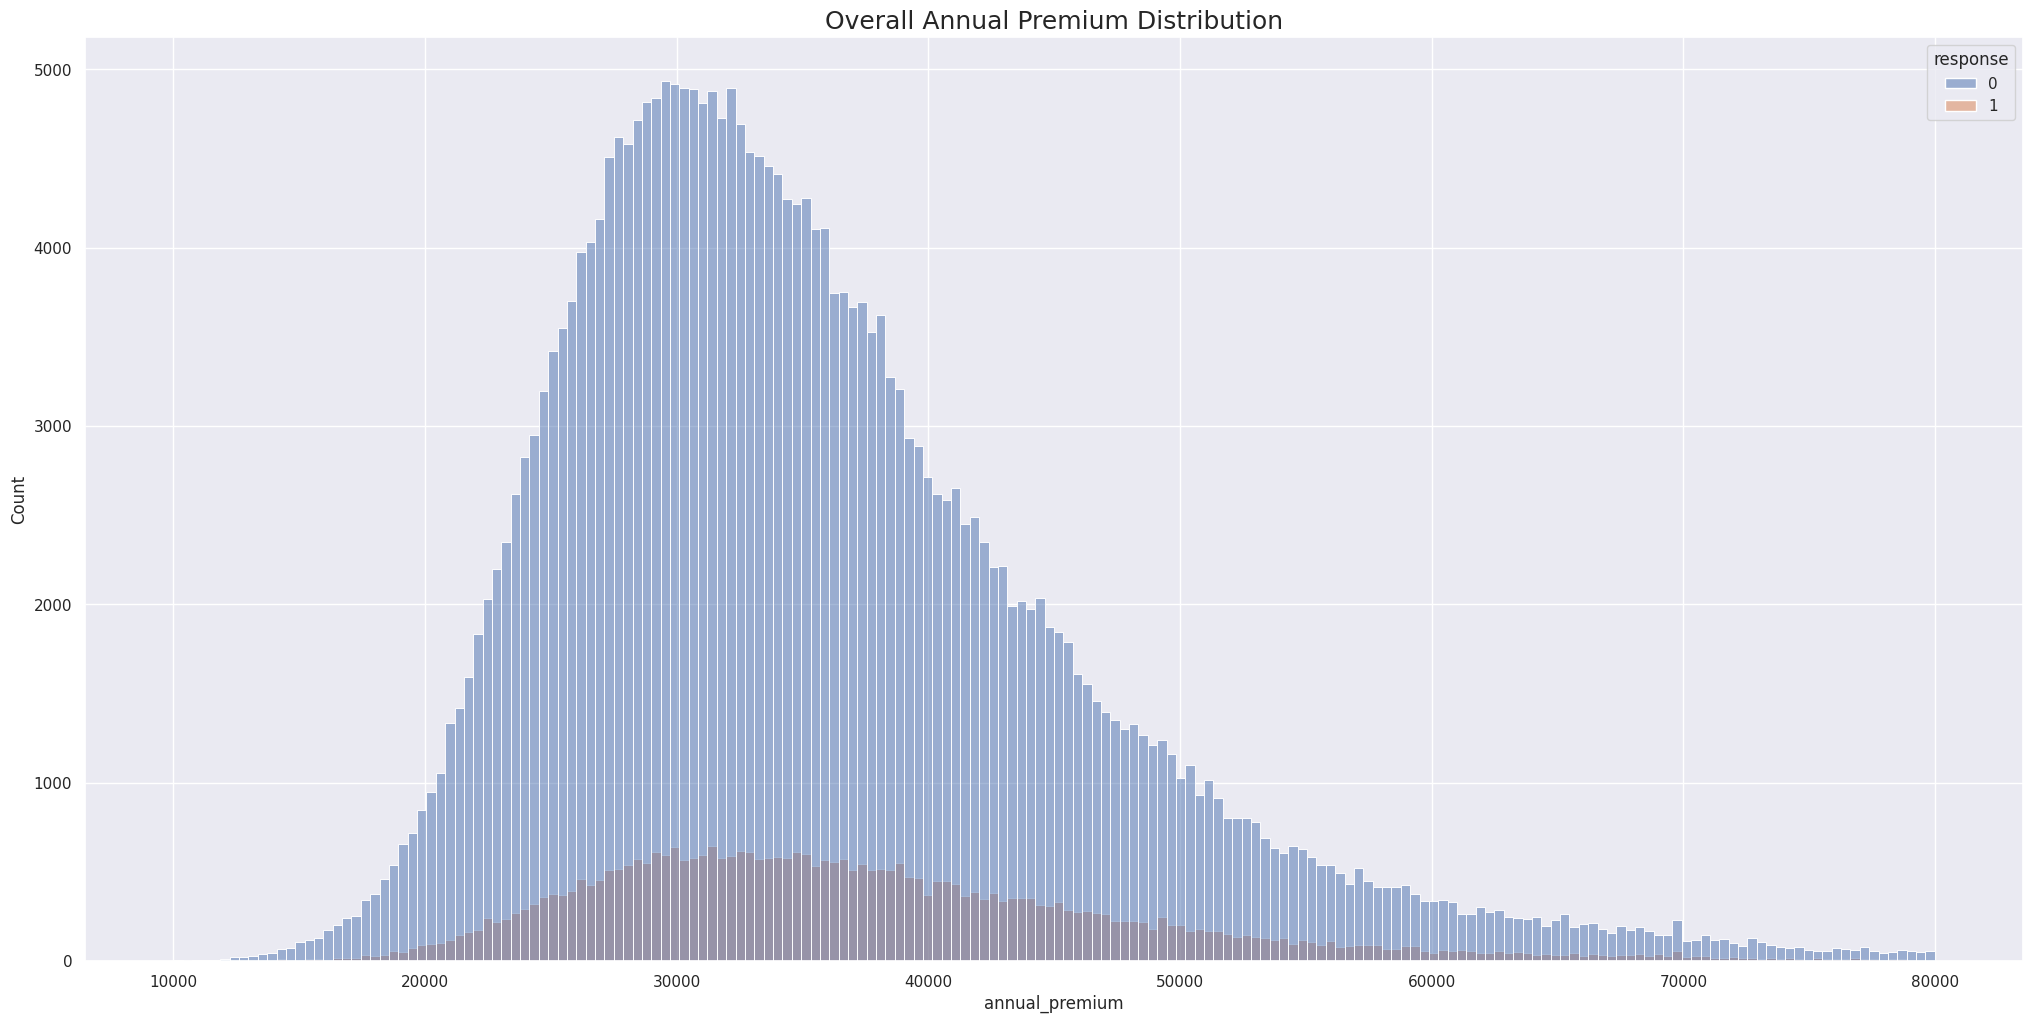

In [130]:
plt.title('Overall Annual Premium Distribution', fontsize=18)
aux3 = df3.loc[ (df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000), :]
sns.histplot(aux3, x='annual_premium', hue='response');

In [131]:
#Nota-se que há uma contagem muito grande (ordem de 65k de entradas) com annual premium padronizado no valor de $2630,00
    #possívelmente o 'plano básico/padrão' da seguradora de saúde

out1 = df3[['annual_premium','response']].groupby('annual_premium').count().sort_values('response',ascending=False).reset_index()
out1.head()

,annual_premium,response
0,2630.0,64877
1,69856.0,140
2,39008.0,41
3,38287.0,38
4,45179.0,38




*   It is important to note that there is a very large count for entries with 'annual_premium' with a fixated value of $2630,00. This is possibly due to a 'standard/default plan' offered by the Health Insurance Company



### H.4 Older clients on the database (Higher vintage count) are 10% more likely to acquire a vehicular insurance..
**False** -> No Significant difference observed while relating 'vintage x response' variables.

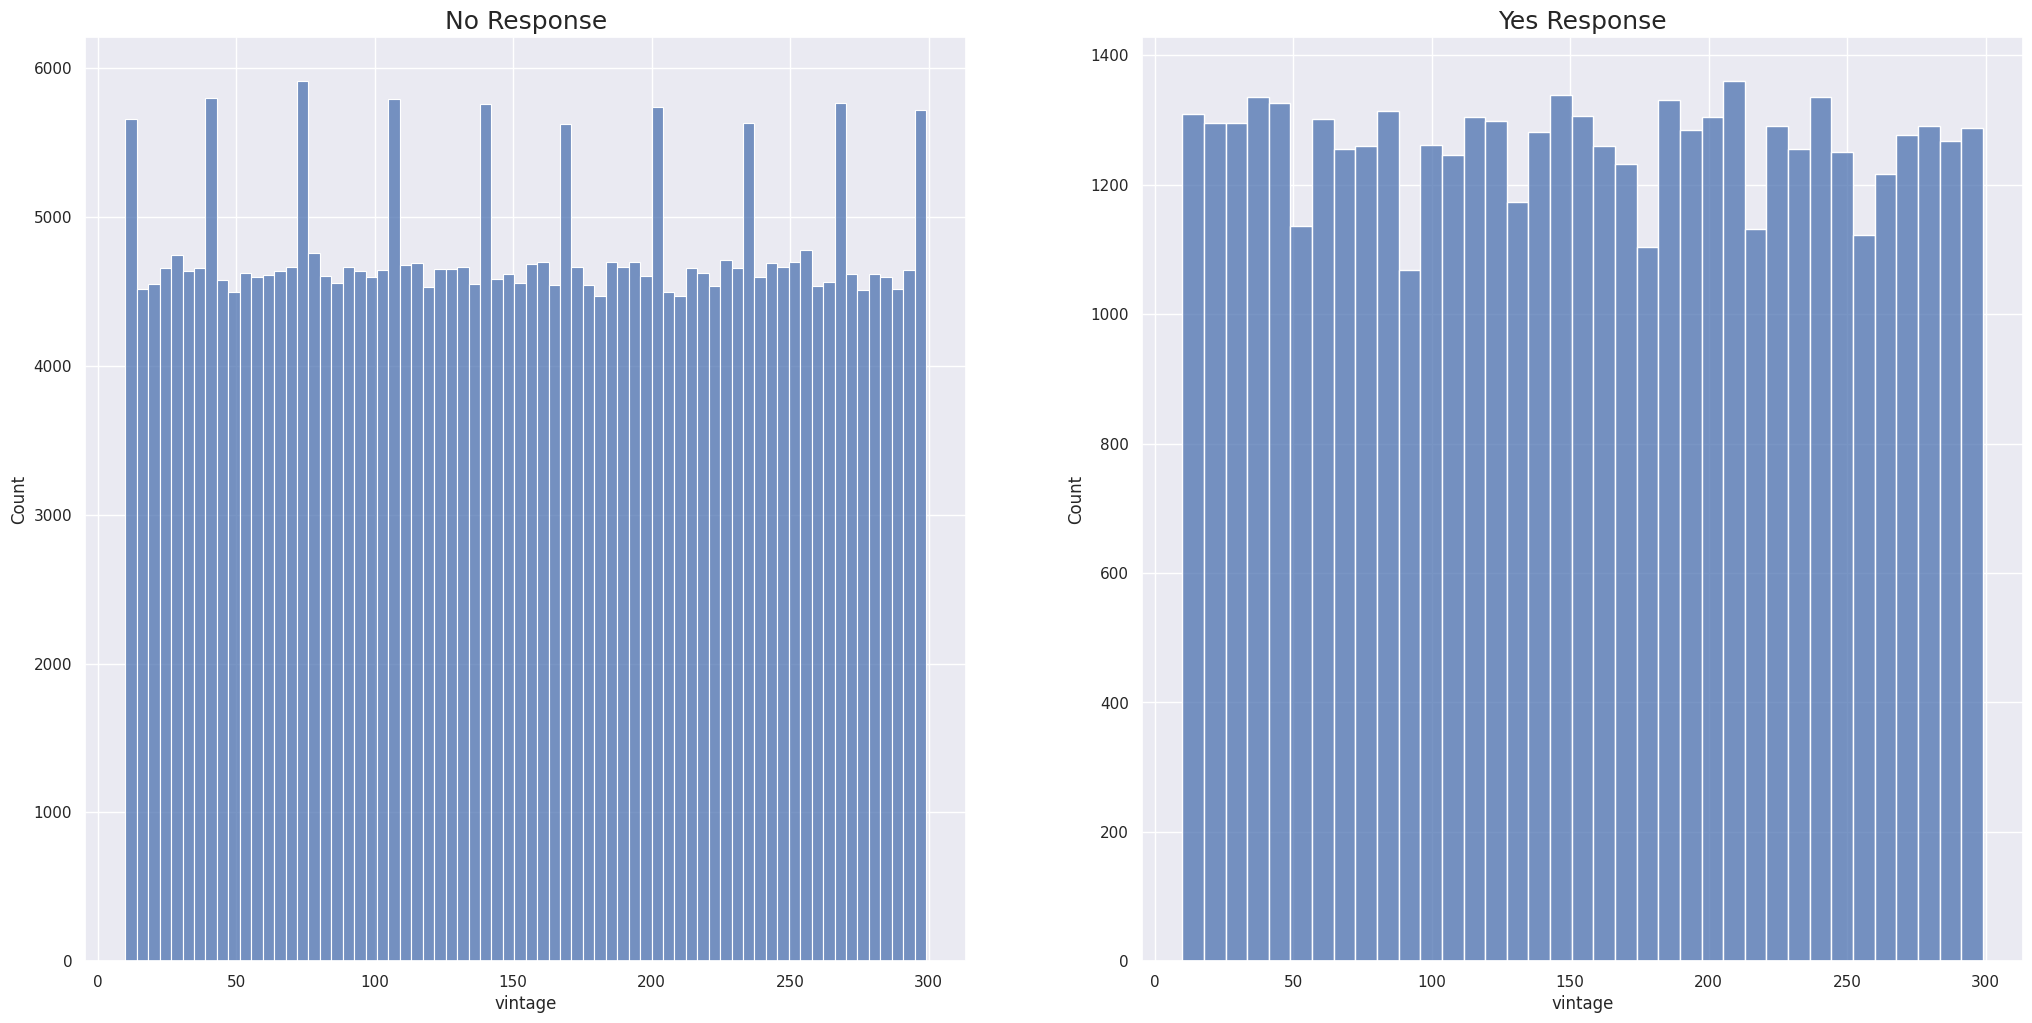

In [132]:
plt.subplot(1,2,1)
plt.title('No Response', fontsize=18)
aux4 = df3.loc[df3['response'] == 0, :]
sns.histplot(aux4, x='vintage');

plt.subplot(1,2,2)
plt.title('Yes Response', fontsize=18)
aux4 = df3.loc[df3['response'] == 1, :]
sns.histplot(aux4, x='vintage');

### H.5 Clients with valid drivers license are 10% more likely to acquire a new vehicular insurance.
**False** -> Although there is a higher proportion (shown as percentages on the contingency table) of interest shown by those who have valid drivers licenses, it is only 7% higher than of those who have not.

In [133]:
aux5 = pd.crosstab(df3['driving_license'], df3['response'])
aux5 = aux5.apply(lambda x: x/x.sum(), axis=1)
aux5

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


### H.6 Clients with older vehicles are 10% more likely to acquire a vehicular insurance.
**True** -> Those who have older cars (Older than 2 years) present a higher percentual proportion for interest in acquiring vehicular insurance compared to the other 'vehicle_age' classes.

In [134]:
df3[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


In [135]:
#Vehicle age score atribution
vehicle_age_dict = {'< 1 Year': 1,
                    '1-2 Year': 2,
                    '> 2 Years': 3}
df3['vehicle_age_score'] = df3['vehicle_age'].map(vehicle_age_dict)

### H.7 Clients whose vehicles were already damaged are 10% more likely to acquire a vehicle insurance.
**True** -> There is a higher percentual proportion for people interested in acquiring vehicular insurance amongst those who had their vehicle damaged at some point.

In [136]:
aux7 = pd.crosstab(df3['vehicle_damage'], df3['response']).apply(lambda x: x/x.sum(), axis = 1)
aux7

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### H.8 Clientes de determinada região são mais propensos a adquirir um plano de seguro veícular.
**Falso** -> Proporcionalmente, não há uma região específica onde o interesse de compra se destaque

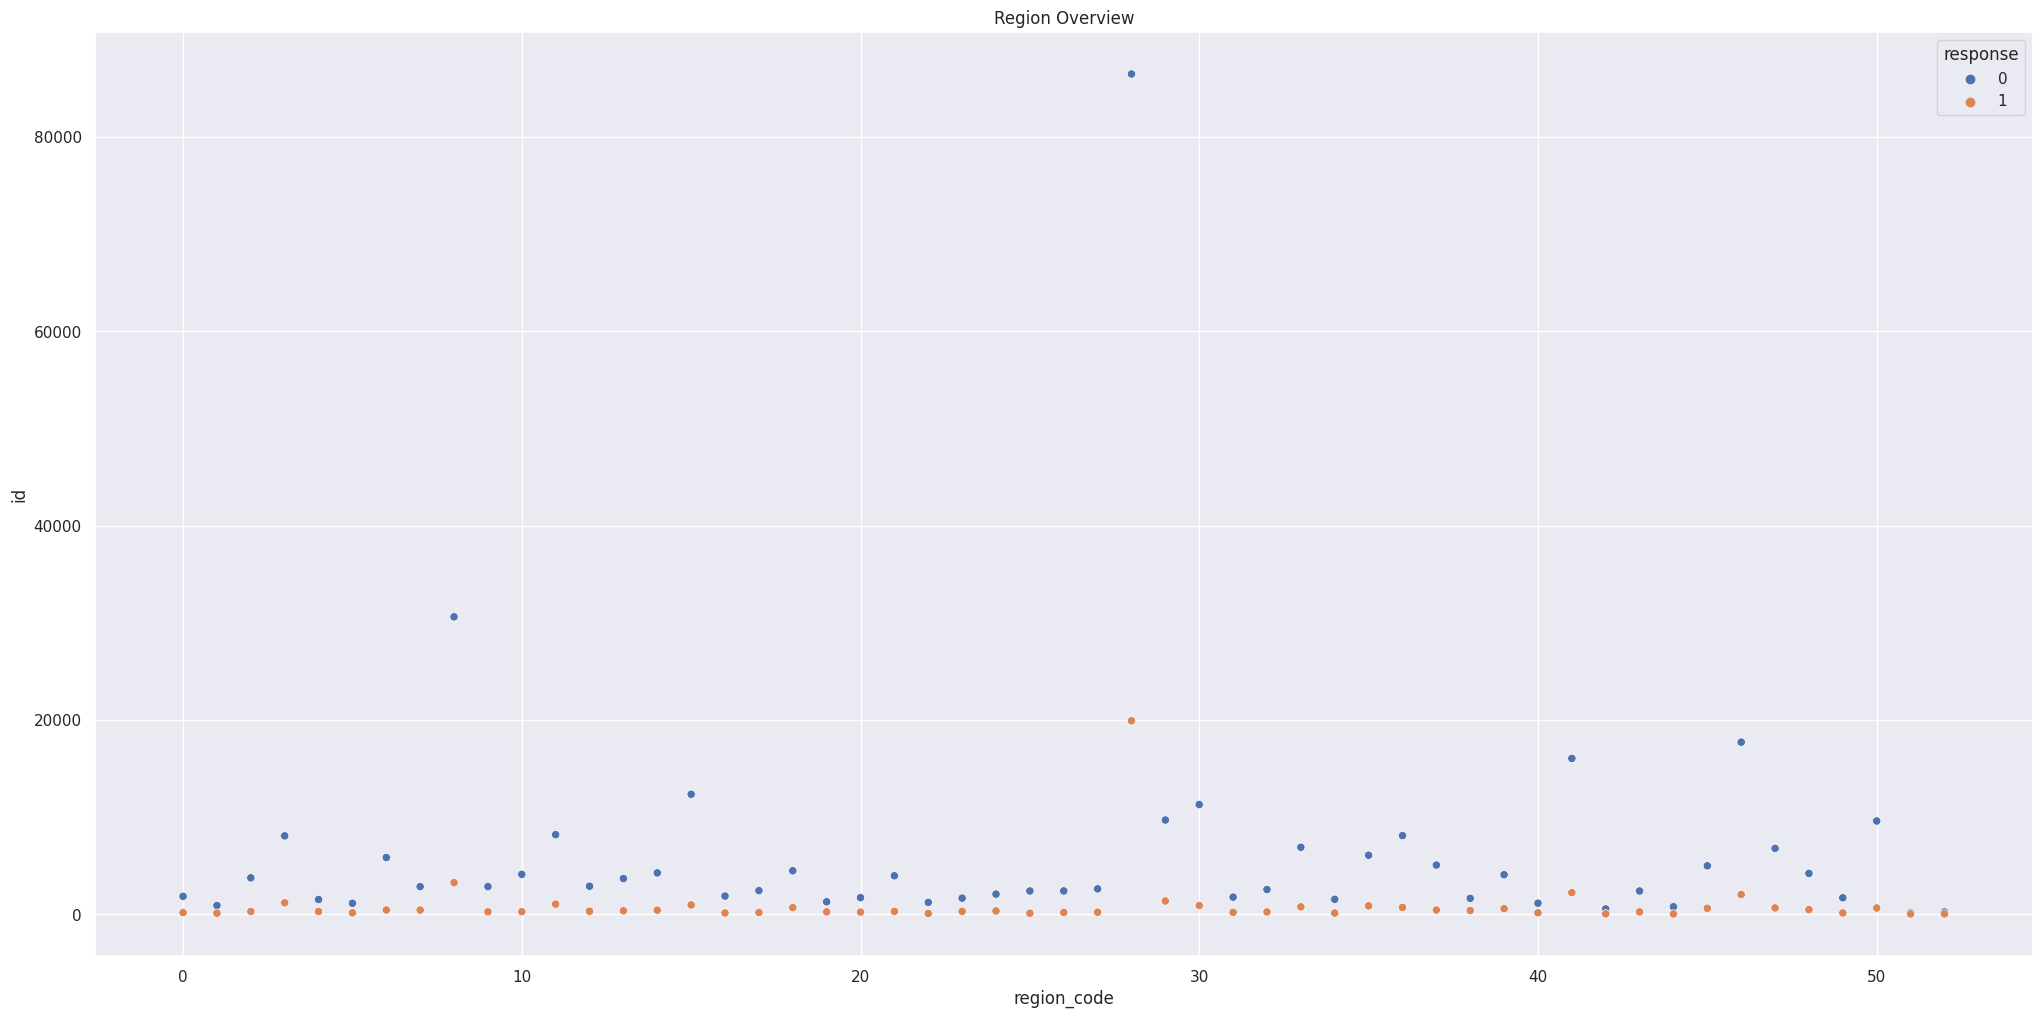

In [137]:
plt.title('Region Overview')
aux8 = df3[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(aux8, x='region_code', y='id', hue='response');

### H.9 Clients of a particular region are 10% more likely to acquire vehicular insurance.
**True** -> Some region code present much larger proportion of interested people in acquiring vehicular insurance, as shown on the stacked bar graph below.

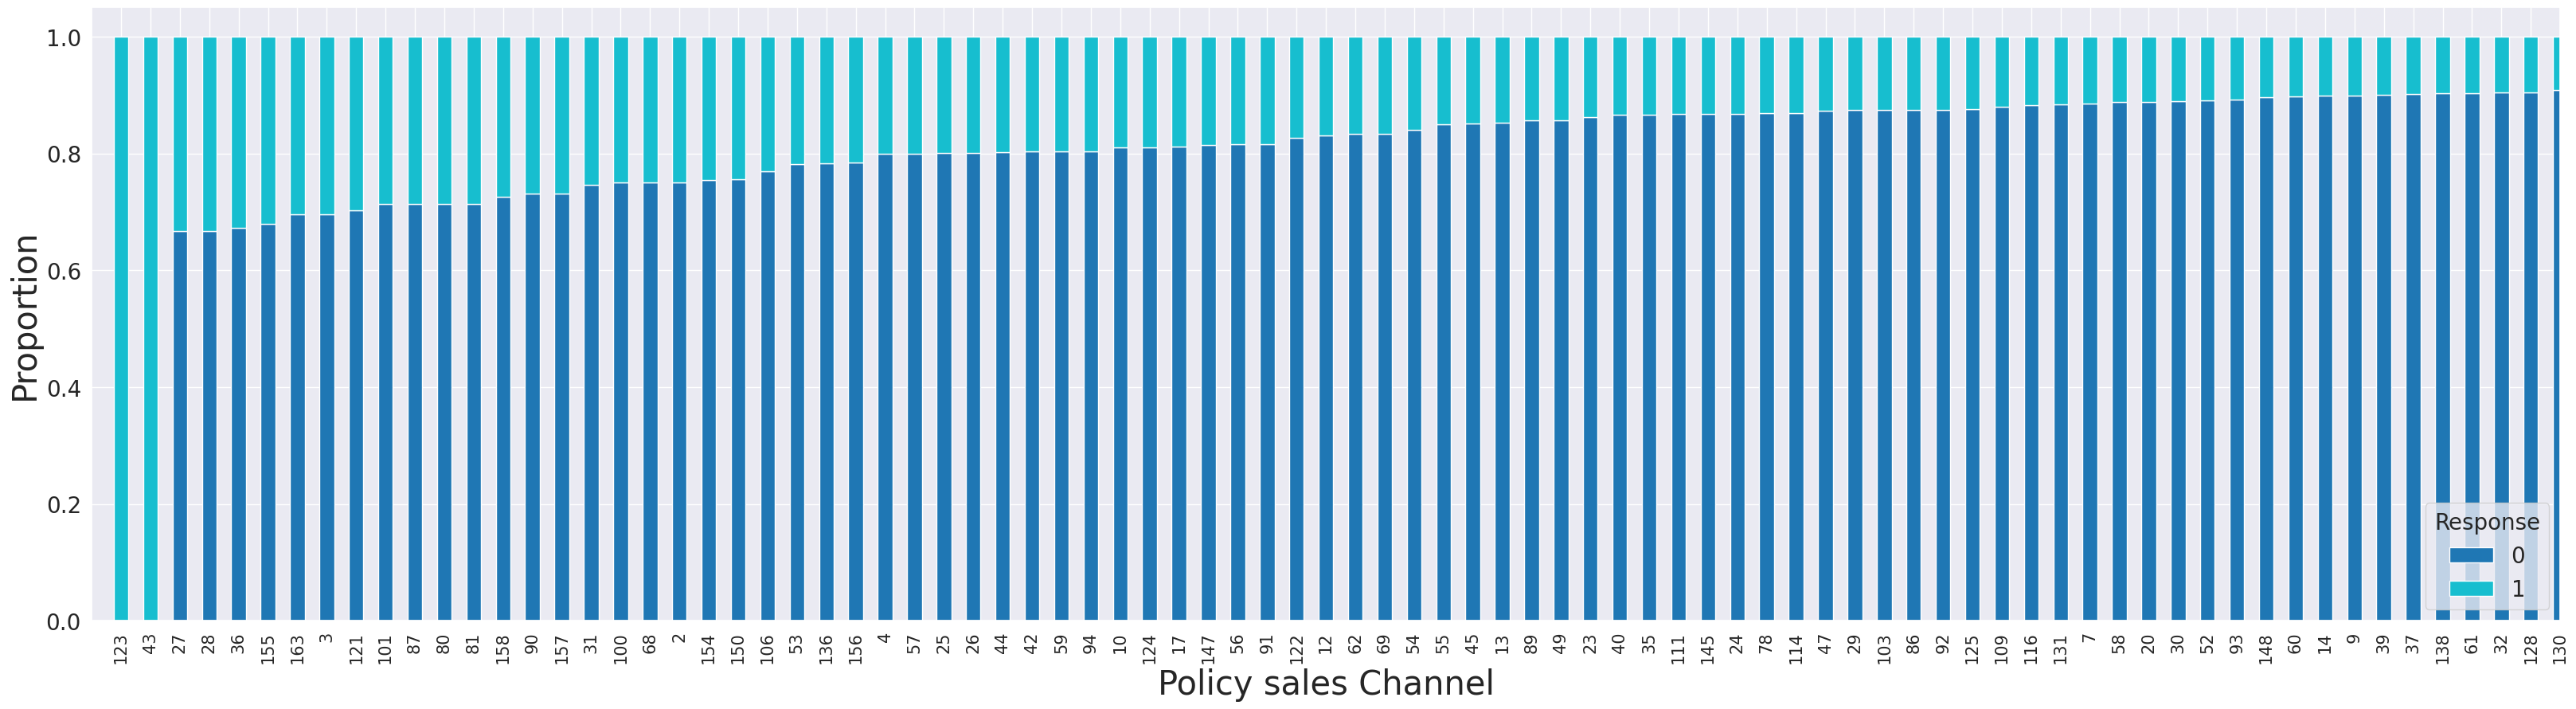

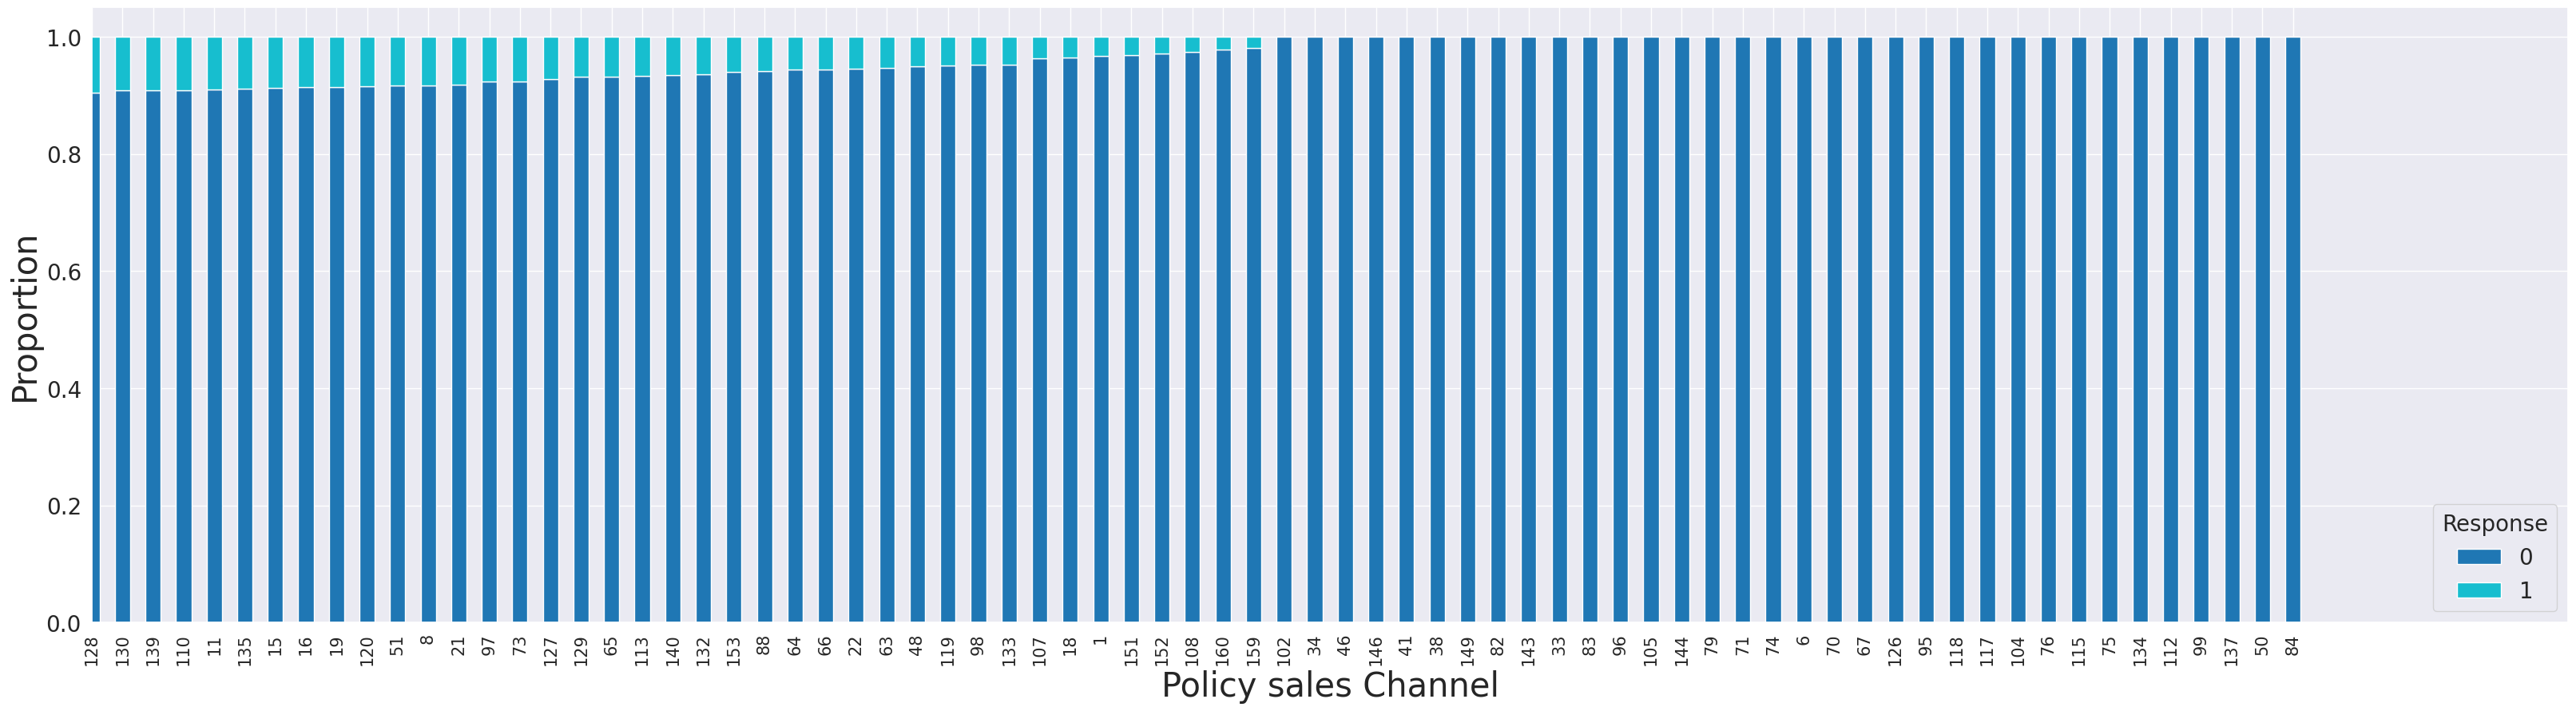

In [138]:
aux9 = pd.crosstab(df3['policy_sales_channel'], df3['response']).apply(lambda x: x/x.sum(), axis = 1).sort_values(1, ascending=False)

ax1 = aux9.plot(kind='bar',
          stacked=True,
          colormap='tab10',
          figsize = (40, 10));
plt.xlabel('Policy sales Channel',fontsize=30);
plt.xticks(fontsize=15);
plt.xlim(-1, 83);
plt.ylabel('Proportion', fontsize = 30);
plt.yticks(fontsize=20);

ax1.legend(loc='lower right', prop={'size': 20}, title_fontsize= 20, title= 'Response');

ax2 = aux9.plot(kind='bar',
          stacked=True,
          colormap='tab10',
          figsize = (40, 10));
plt.xlabel('Policy sales Channel',fontsize=30);
plt.xticks(fontsize=15);
plt.xlim(82, 163);
plt.ylabel('Proportion', fontsize = 30);
plt.yticks(fontsize=20);

ax2.legend(loc='lower right', prop={'size': 20}, title_fontsize= 20, title= 'Response');

### 3.2.2 EDA's Summary

In [139]:
from tabulate import tabulate

In [140]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'True', 'Low'], #Possible Data Leakage: Lack of Interested if those who already have vehicular insurance in acquiring a new one.
       ['H3', 'False', 'Low'],
       ['H4', 'False', 'Low'],
       ['H5', 'False', 'Low'],
       ['H6', 'True', 'High'],  #Proportionaly, almost half of those who have cars over 2 years of age showed interest in acquiring vehicular insurance
       ['H7', 'True', 'High'],  #There is more than 10% diference amongst the total of interested people who had damaged vehicles compared to non-damaged ones.
       ['H8', 'False', 'Low'],
       ['H9', 'True', 'High']] #Some region codes show a much larger proportion of interested people.

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            True          Low
H3            False         Low
H4            False         Low
H5            False         Low
H6            True          High
H7            True          High
H8            False         Low
H9            True          High


### 3.2.3 Feature Engineering (Bivariate Features)



*   The following features were created in order to further study patterns regarding features that had shown little relevance on EDA. This was done by combining 'annual_premium' and 'vintage' feature to other variables.



In [141]:
#annual premium paid per day
df3['annual_premium_per_day'] = df3['annual_premium']/df3['vintage']

#annual premium divided per age
df3['annual_premium_per_age'] = df3['annual_premium']/df3['age']

#vintage_per_age
df3['vintage_per_age'] = df3['vintage']/df3['age']



*   The following features were created by establishing a score to both 'scored_sales_channel' and 'region_code' entries which had larger proportion of interested people with interest to acquire vehicular insurance



In [142]:
#Creation of the dictionary that will designate each policy sales channel to its score
aux9_2 = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').value_counts(normalize=True).reset_index()
aux9_2 = aux9_2.drop(aux9_2[aux9_2['response'] == 0].index).sort_values(0)
aux9_2['scored_sales_channel'] = aux9_2[0].apply(lambda x: 5 if x > 0.3 else
                                                 4 if (x <= 0.3) & (x > 0.25) else
                                                 3 if (x <= 0.25) & (x > 0.2) else
                                                 2 if (x <= 0.2) & (x > 0.1) else 1)
scored_sales_channel = {channel: score for channel, score in zip(aux9_2['policy_sales_channel'], aux9_2['scored_sales_channel'])}

#Appending the scored channel to the original dataframe, on its respective ids
df3['scored_sales_channel'] = df3['policy_sales_channel'].map(scored_sales_channel)
df3['scored_sales_channel'].fillna(1, inplace=True)
df3['scored_sales_channel']= df3['scored_sales_channel'].astype(int64)

In [143]:
#Creation of the dictionary that will designate each region code to its score
aux8_2 = df3[['region_code', 'vehicle_damage', 'response']].groupby('region_code').value_counts(normalize=True).reset_index()
aux8_2 = aux8_2.loc[(aux8_2['response'] == 1) & (aux8_2['vehicle_damage'] == 1), :].sort_values(0)
aux8_2['region_score'] = aux8_2[0].apply(lambda x: 4 if x >= 0.15 else
                                        3 if (x < 0.15) & (x >= 0.10) else
                                        2 if (x < 0.10) & (x >= 0.05) else 1)
region_insured_dict = {region: score for region, score in zip(aux8_2['region_code'], aux8_2['region_score'])}

#Appending the scored regions to the original dataframe, on its respective ids
df3['region_score'] = df3['region_code'].map(region_insured_dict)
df3['region_score'].fillna(1, inplace=True)
df3['region_score'] = df3['region_score'].astype(int64)

## 3.3 Multivariative Analysis

In [144]:
df3.dtypes

id                          int64
age                         int64
region_code                 int64
policy_sales_channel        int64
previously_insured          int64
annual_premium            float64
vintage                     int64
driving_license             int64
vehicle_age                object
vehicle_damage              int64
response                    int64
vehicle_age_score           int64
annual_premium_per_day    float64
annual_premium_per_age    float64
vintage_per_age           float64
scored_sales_channel        int64
region_score                int64
dtype: object

In [145]:
reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'scored_sales_channel', 'vehicle_age_score', 'region_score',
       'annual_premium_per_day', 'annual_premium_per_age',
       'vintage_per_age', 'response']

df3 = df3.reindex(columns=reorder_columns)

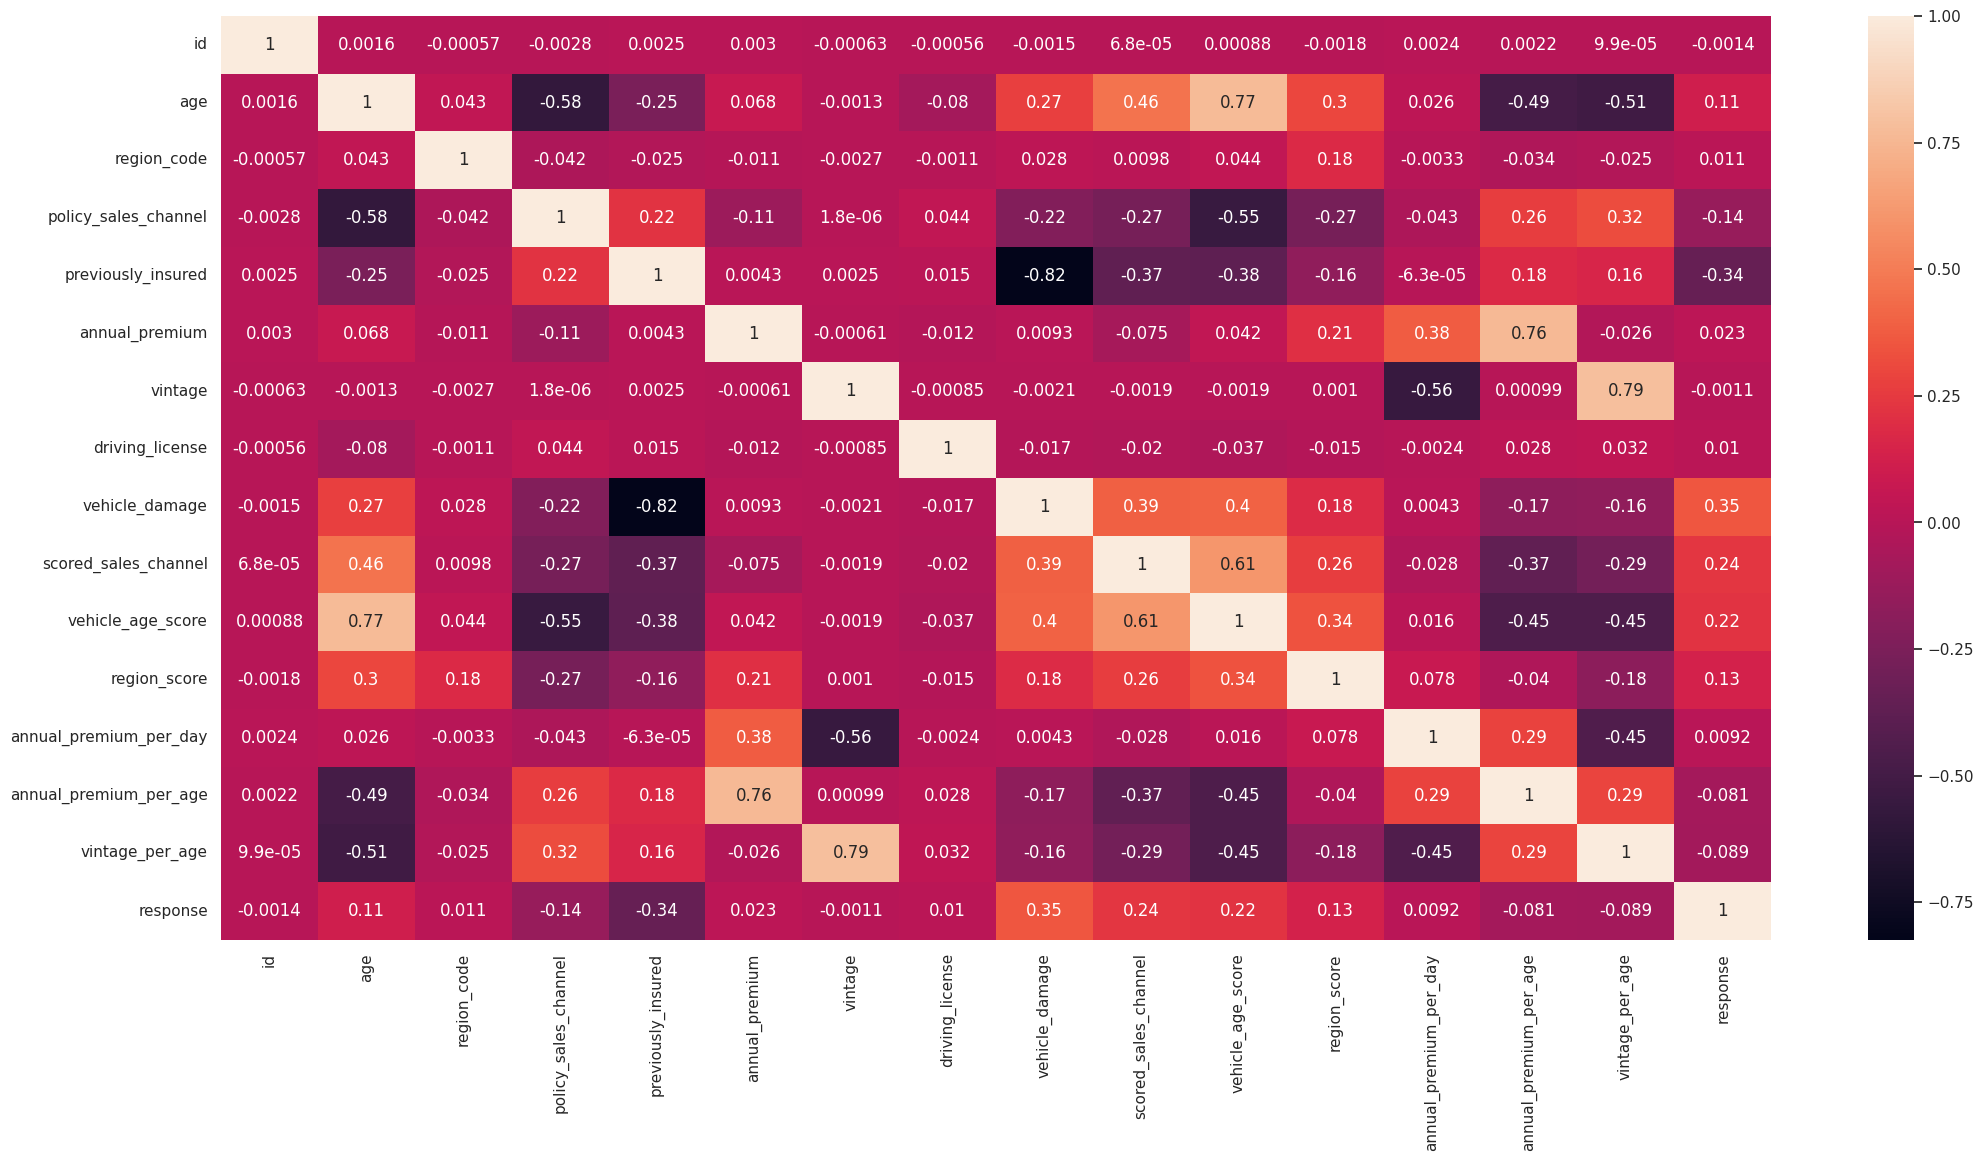

In [146]:
df3_num = df3.select_dtypes(include=['int64', 'float64'])
correlation = df3_num.corr(method='pearson')
sns.heatmap(correlation, annot=True);



*   By Multivariative analysis, we can conclude that the features that involved scoring presented better correlation to our class variable (response).
*   The same **cannot** be said about the other bivariate features .



# 4.0 DATA PREPARATION

In [147]:
df4 = df3.copy()

In [148]:
df4.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score,annual_premium_per_day,annual_premium_per_age,vintage_per_age,response
0,7,23,11,152,0,23367.0,249,1,< 1 Year,1,1,1,3,93.843373,1015.956522,10.826087,0
1,13,41,15,14,1,31409.0,221,1,1-2 Year,0,2,2,2,142.122172,766.073171,5.390244,0
2,18,25,35,152,1,46622.0,299,1,< 1 Year,0,1,1,3,155.926421,1864.880000,11.960000,0
3,31,26,8,160,0,2630.0,136,1,< 1 Year,0,1,1,2,19.338235,101.153846,5.230769,0
4,39,45,8,124,0,42297.0,264,1,1-2 Year,1,2,2,2,160.215909,939.933333,5.866667,0


In [149]:
x_split = df4.drop('response', axis=1)
y_split = df4['response'].copy()

X_train, X_validation , y_train, y_validation = train_test_split(x_split, y_split, test_size=0.2, random_state=32)

df4 = pd.concat([X_train, y_train], axis=1)

## 4.1 Normalization

In [150]:
ss = StandardScaler()

#annual_premium
df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']].values)

#annual_premium_per_day
df4['annual_premium_per_day'] = ss.fit_transform(df4[['annual_premium_per_day']].values)

#annual_premium_per_age
df4['annual_premium_per_age'] = ss.fit_transform(df4[['annual_premium_per_age']].values)

## 4.2 Standardization (Reescaling)

In [151]:
#Analyze the occurance of outliers for further reescale method
mms = MinMaxScaler()

#age
df4['age'] = mms.fit_transform(df4[['age']].values)
#pickle.dump(mms, open('models/age_scaler.pkl'), 'wb')

#vintage
df4['vintage'] = mms.fit_transform(df4[['vintage']].values)

#vintage_per_age
df4['vintage_per_age'] = mms.fit_transform(df4[['vintage_per_age']].values)

## 4.3 Data Transformation (Encoding)

In [152]:
#region_code - Frequency Encoding
fe = df4.groupby('region_code').size()/len(df4)
df4.loc[:, 'region_code'] = df4['region_code'].map(fe)

#policy_sales_channel - Mean Target Encoding
te = df4.groupby('policy_sales_channel')['response'].mean()
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(te)

#NOTA -> For Vehicle Age, the created feature 'vehicle_age_score' was maintained, given that it functions as an ordinal encoder for 'vehicle_age'.
#vehicle_age - One Hot Encoding
df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])



## 4.4 Validation Data Preparation

In [153]:
#age
X_validation.loc[:, 'age'] = mms.fit_transform(X_validation[['age']].values)

#region_code
X_validation.loc[:, 'region_code'] = X_validation.loc[:, 'region_code'].map(fe)

#policy_sales_channel
X_validation.loc[:, 'policy_sales_channel'] = X_validation.loc[:, 'policy_sales_channel'].map(te)

#annual_premium
X_validation.loc[:, 'annual_premium'] = ss.fit_transform(X_validation[['annual_premium']].values)

#vintage
X_validation.loc[:, 'vintage'] = mms.fit_transform(X_validation[['vintage']].values)

#vehicle_age
X_validation.loc[:, 'vehicle_age'] = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

#annual_premium_per_day
X_validation.loc[:, 'annual_premium_per_day'] = ss.fit_transform(X_validation[['annual_premium_per_day']].values)

#annual_premium_per_age
X_validation.loc[:, 'annual_premium_per_age'] = ss.fit_transform(X_validation[['annual_premium_per_age']].values)

#vintage_per_age
X_validation.loc[:, 'vintage_per_age'] = mms.fit_transform(X_validation[['vintage_per_age']].values)

##fillna
X_validation = X_validation.fillna(0)


# 5.0 FEATURE SELECTION

In [154]:
df5 = df4.copy()

## 5.1 Train-Test Split

In [155]:
training_data, testing_data = X_train, X_validation

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 304887
No. of testing examples: 76222


## 5.2 Feature Selection (w/ Random Forest)

In [156]:
X_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

#Define Random Forest Regressor
rf = ExtraTreesClassifier(n_estimators=250, random_state=32, n_jobs=-1)
rf.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=32)

Feature Ranking:
                  feature  importance
0  annual_premium_per_day    0.130239
0         vintage_per_age    0.128053
0                 vintage    0.123414
0  annual_premium_per_age    0.122168
0          annual_premium    0.105709
0                     age    0.101650
0          vehicle_damage    0.066366
0    policy_sales_channel    0.057868
0             region_code    0.056272
0      previously_insured    0.054880
0    scored_sales_channel    0.018152
0            region_score    0.011103
0    vehicle_age_< 1 Year    0.009518
0       vehicle_age_score    0.007085
0    vehicle_age_1-2 Year    0.005072
0   vehicle_age_> 2 Years    0.001923
0         driving_license    0.000528


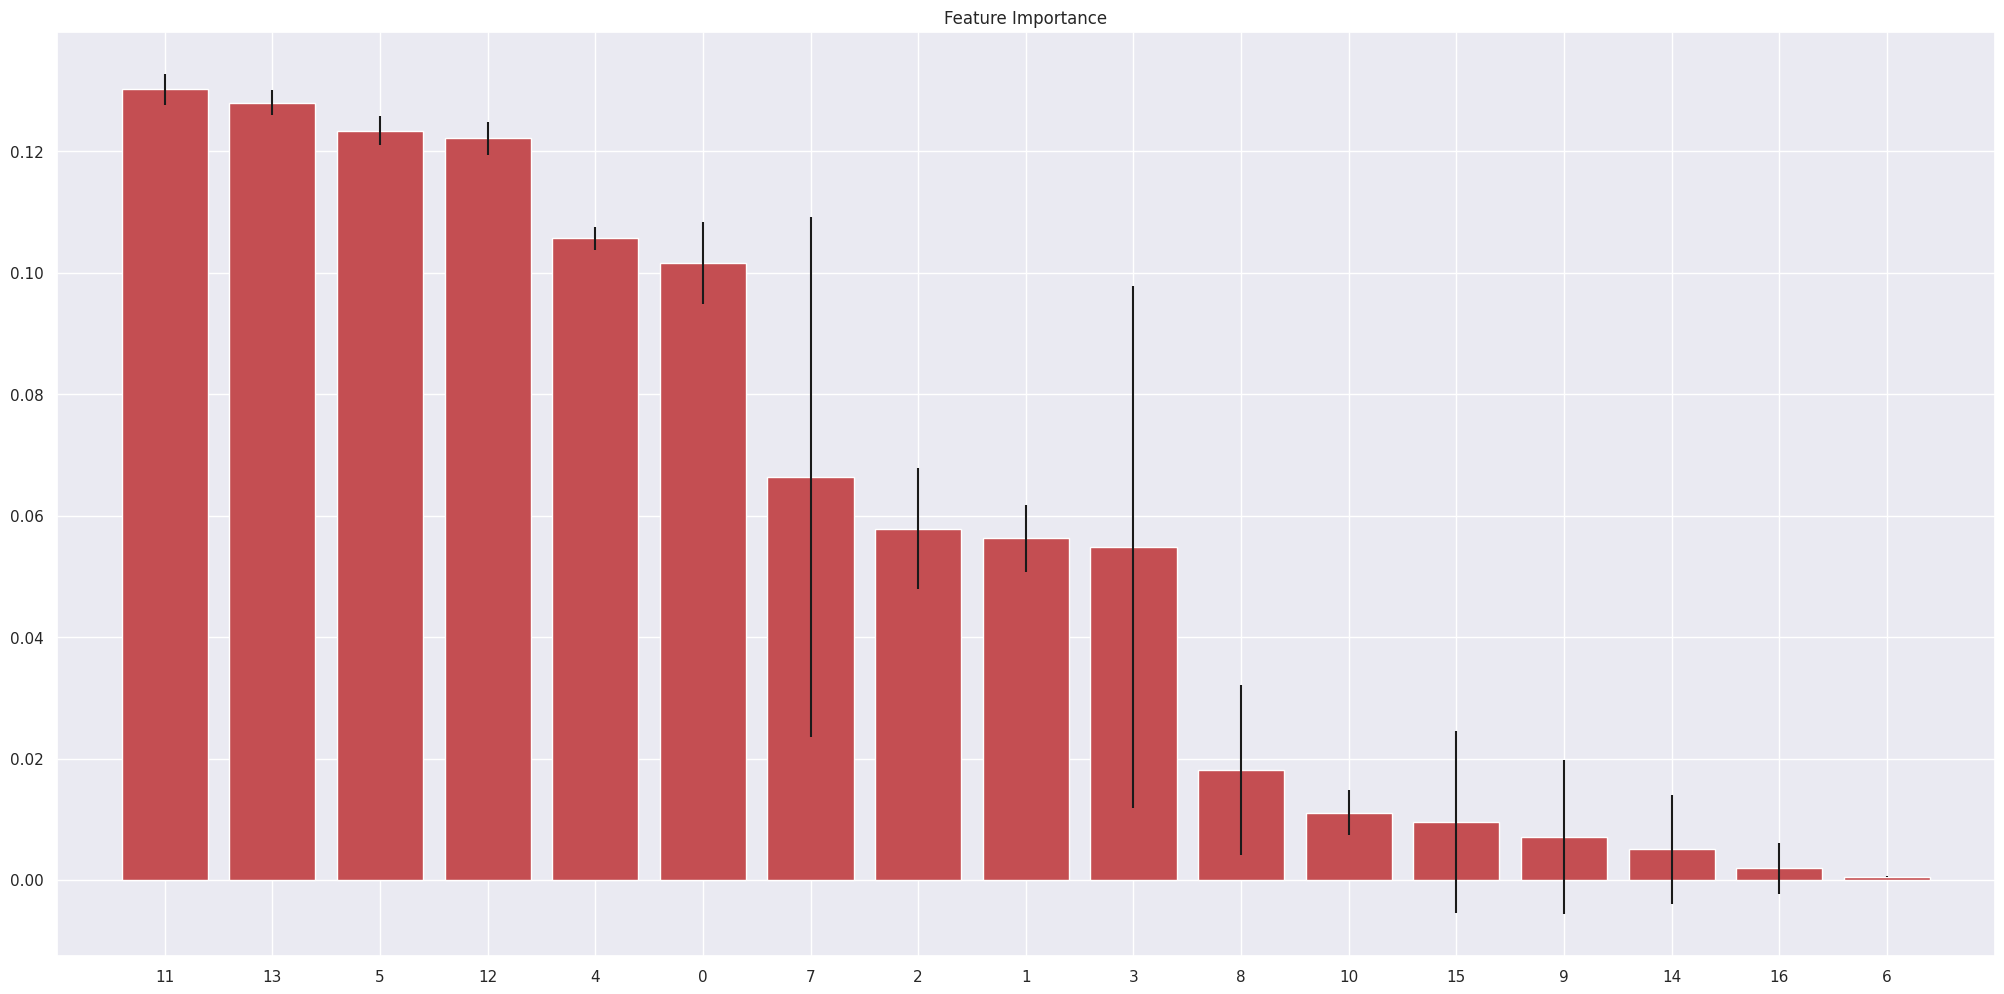

In [157]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print('Feature Ranking:')
df = pd.DataFrame()
for i, j in zip(X_train_n, rf.feature_importances_):
    aux_imp = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux_imp], axis=0)

print(df.sort_values('importance', ascending=False))

#Plot the impurity based feature importance target
plt.figure()
plt.title('Feature Importance')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks( range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

**Feature Selection Results**:



*   By EDA and Data Analysis: Age, vehicle_age, vehicle_damage, region_code, policy_sales_channel, scored_sales_channel, region_score, vehicle_age_score
*   By Random Forest Feature Selection: annual_premium_per_day, vintage_per_age,
vintage, annual_premium_per_age, annual_premium.



# 6.0 Machine Learning



*  **IMPORTANT** -> The following Cross Validation procedures were executed by establishing the k-fold number as being 4, so that its test dataset matches the initial validation dataset in number of rows. This is done so because in order to compare 'recall@k' values, the size of a given dataset alters the analysis procedure for this metric, hence why it is needed to establish this base criteria.
*  Also note that all '@k' metrics were obtained by establishing its value
 as 'k=20000', such as our initial business problem requires.


In [158]:
df6 = df5.copy()

In [159]:
#cols_selected = [ 'annual_premium_per_day', 'vintage_per_age', 'vintage',
#                  'annual_premium_per_age', 'annual_premium', 'age',
#                  'vehicle_damage', 'region_code', 'previously_insured']

cols_selected = [ 'annual_premium_per_day', 'vintage_per_age', 'vintage',
                  'annual_premium_per_age', 'annual_premium', 'age',
                  'vehicle_damage', 'region_code', 'policy_sales_channel',
                  'scored_sales_channel', 'region_score', 'vehicle_age_score']

x_train = df6[ cols_selected ]
x_validation = X_validation[ cols_selected ]

## 6.1 Dummy/Baseline Model



*   The Dummy model shows the probability of randomly classifying a given entry as 1 or 0 as 50% for each class.



In [160]:
dummy = DummyClassifier()

#Model Training
dummy.fit(x_train, y_train)

#Model Prediction
yhat_dummy = dummy.predict_proba( x_validation )

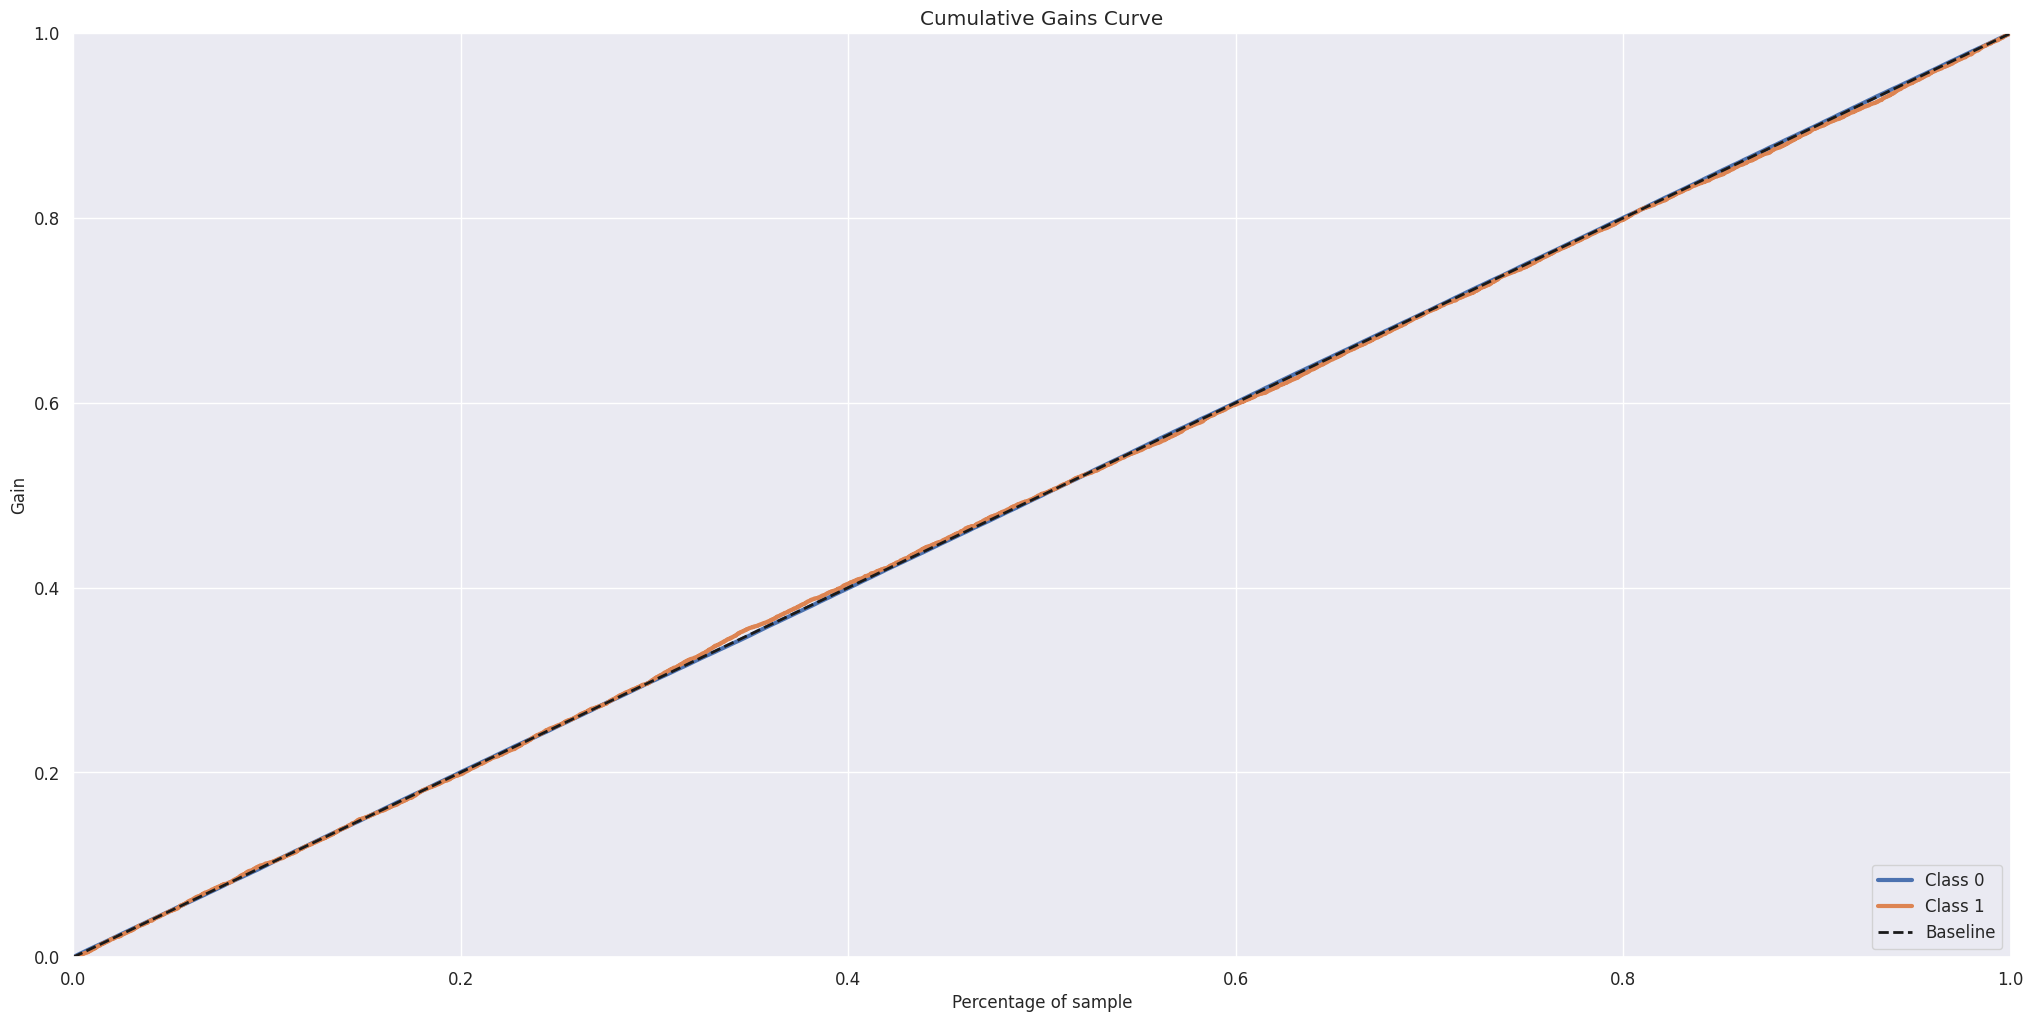

In [161]:
#Acumulative Gain Curve
skplt.metrics.plot_cumulative_gain( y_validation, yhat_dummy);

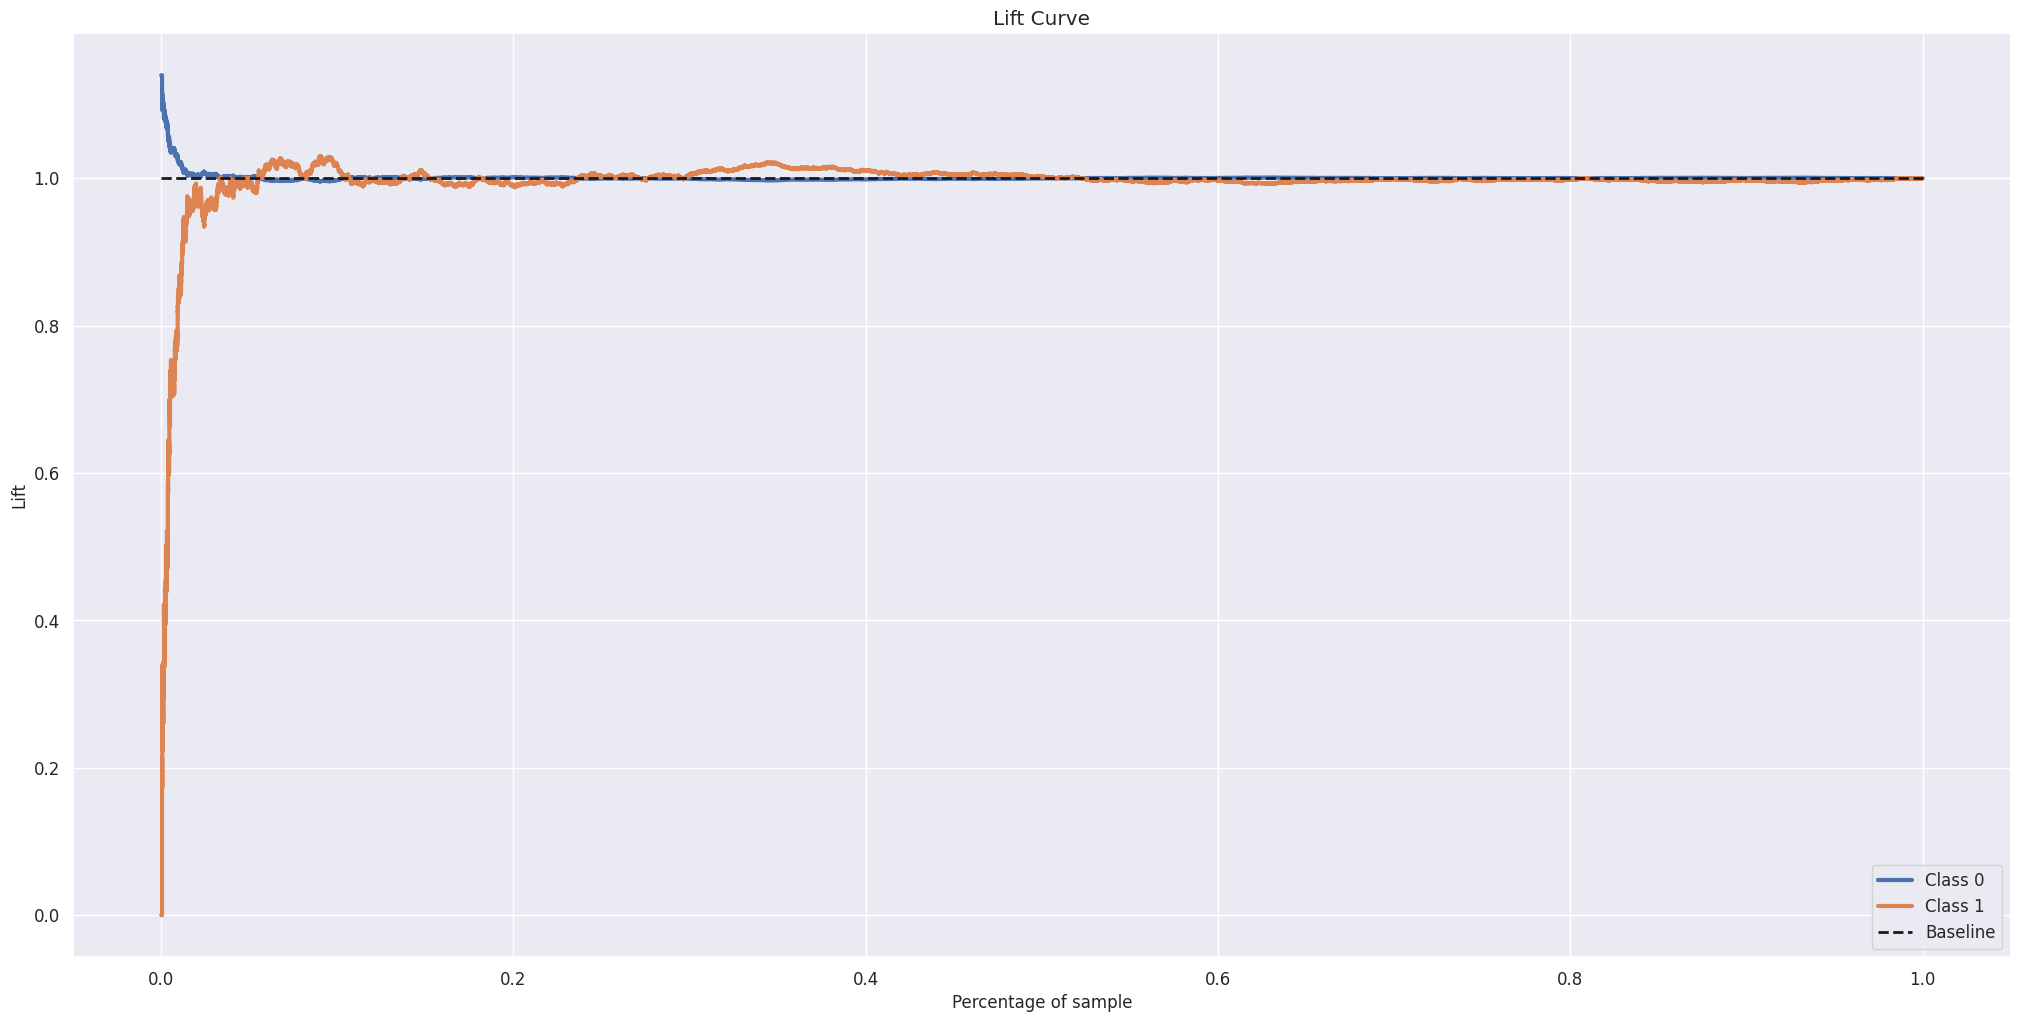

In [162]:
#Lift Gain Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_dummy);

In [163]:
dummy_score = ml_top_k_scores('Dummy', y_validation, yhat_dummy, 20000)
dummy_score

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.123,0.2633,0.1677


In [164]:
dummy_score_cv = ml_cv('Dummy Model', dummy, x_train, y_train)
dummy_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,Dummy Model,0.12 +/- 0.00127,0.27 +/- 0.00271,0.17 +/- 0.00173


## 6.2 KNN

In [165]:
knn = KNeighborsClassifier(n_neighbors=7)

#Model Training
knn.fit(x_train, y_train)

#Model Prediction
yhat_knn = knn.predict_proba( x_validation )

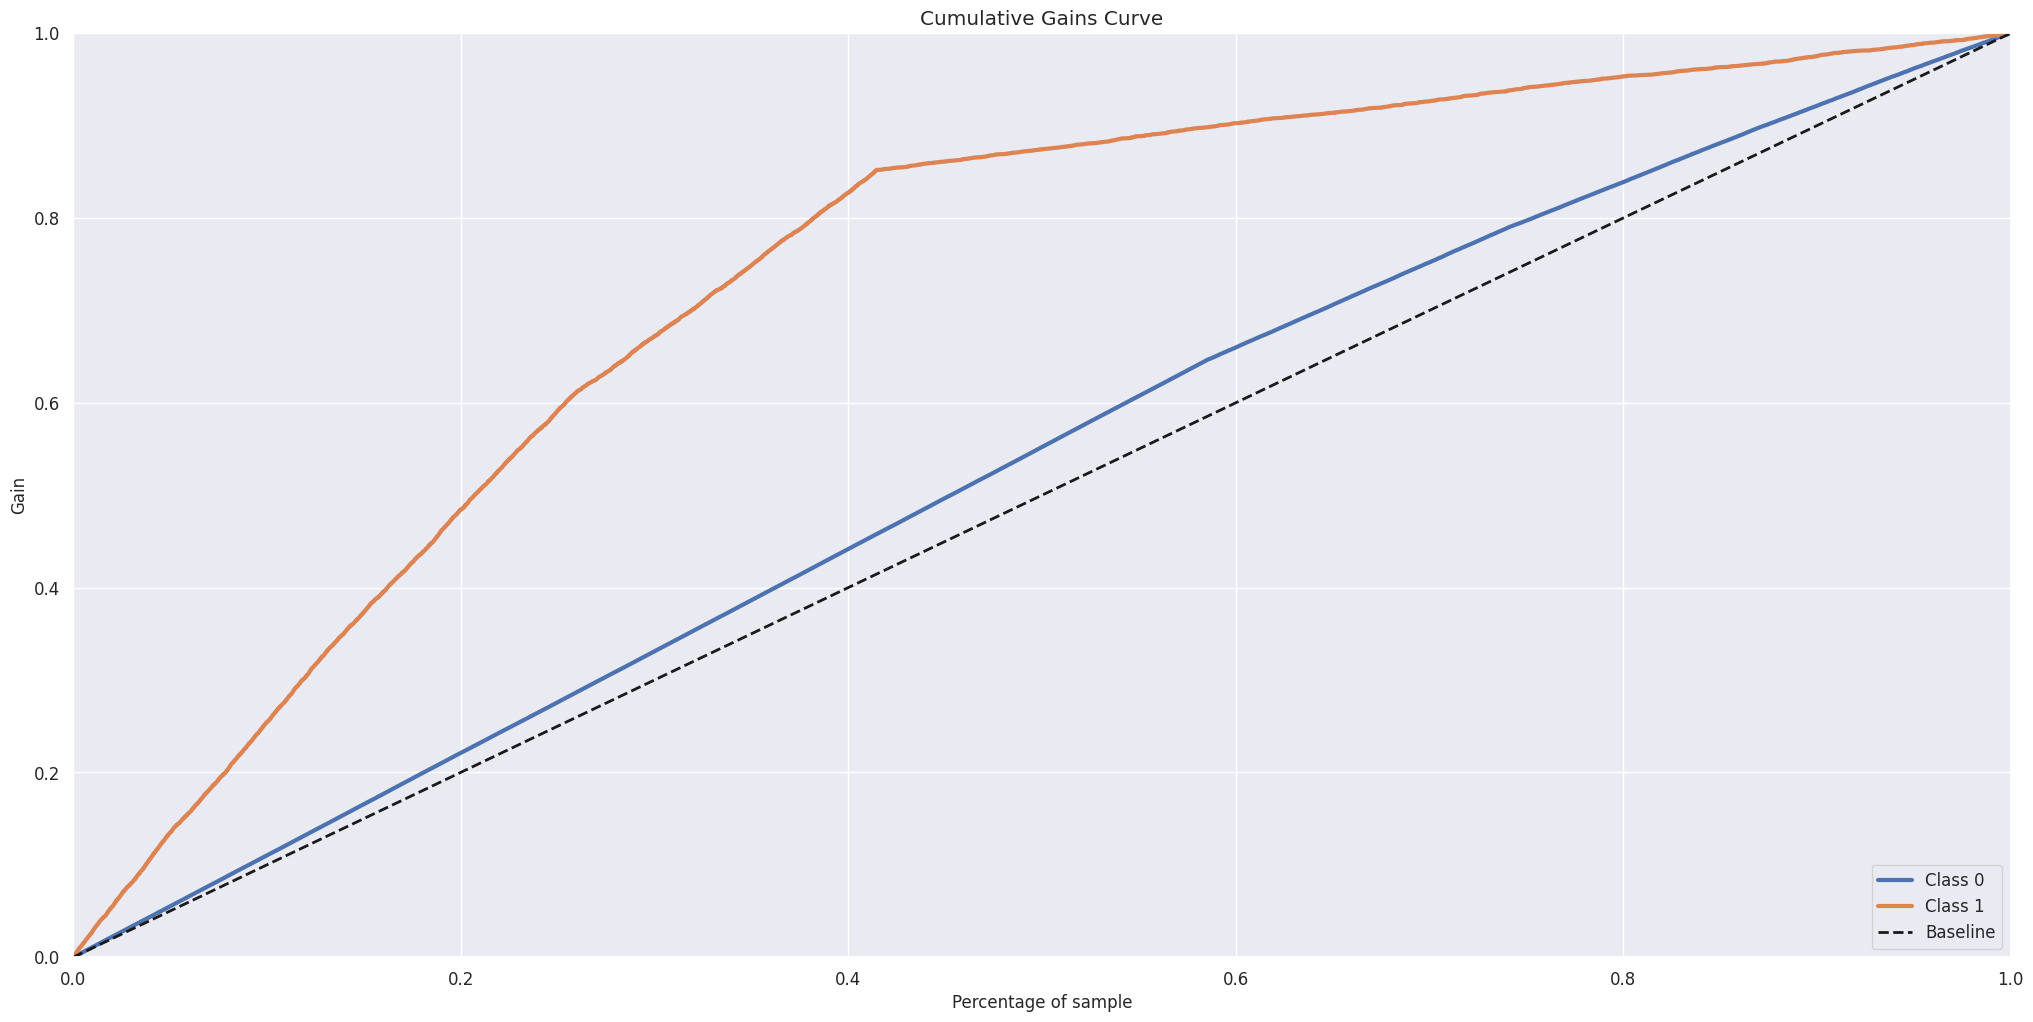

In [166]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn);

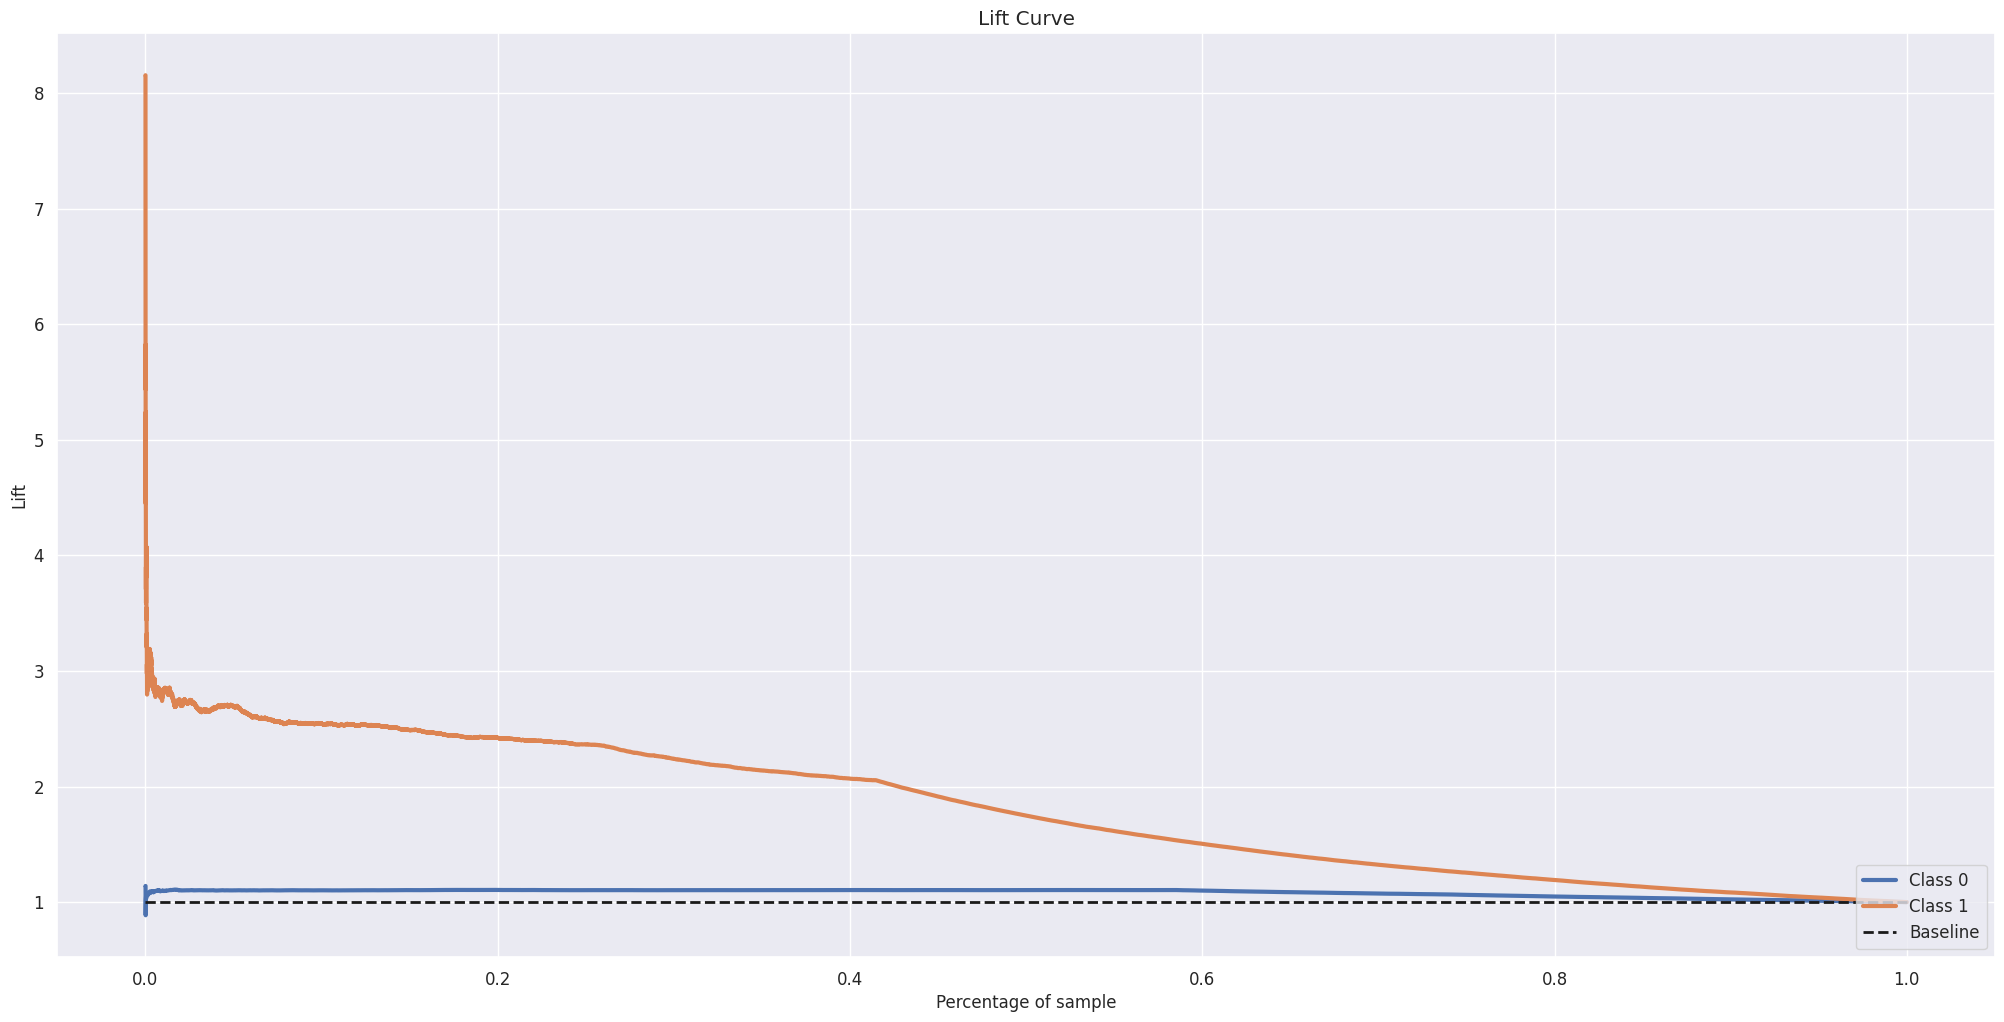

In [167]:
#Lift Curve Gain
skplt.metrics.plot_lift_curve(y_validation, yhat_knn);

In [168]:
knn_score = ml_top_k_scores('KNN Model', y_validation, yhat_knn, 20000)
knn_score

,Precision_at_k,Recall_at_k,F1_at_k
KNN Model,0.2878,0.6157,0.3922


In [169]:
knn_score_cv = ml_cv('KNN Model', knn, x_train, y_train)
knn_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,KNN Model,0.29 +/- 0.00118,0.61 +/- 0.00254,0.39 +/- 0.00161


## 6.3 Logistic Regression

In [170]:
lr = LogisticRegression( random_state=32 )

#Model Training
lr.fit (x_train, y_train)

#Prediction Model
yhat_lr = lr.predict_proba( x_validation )

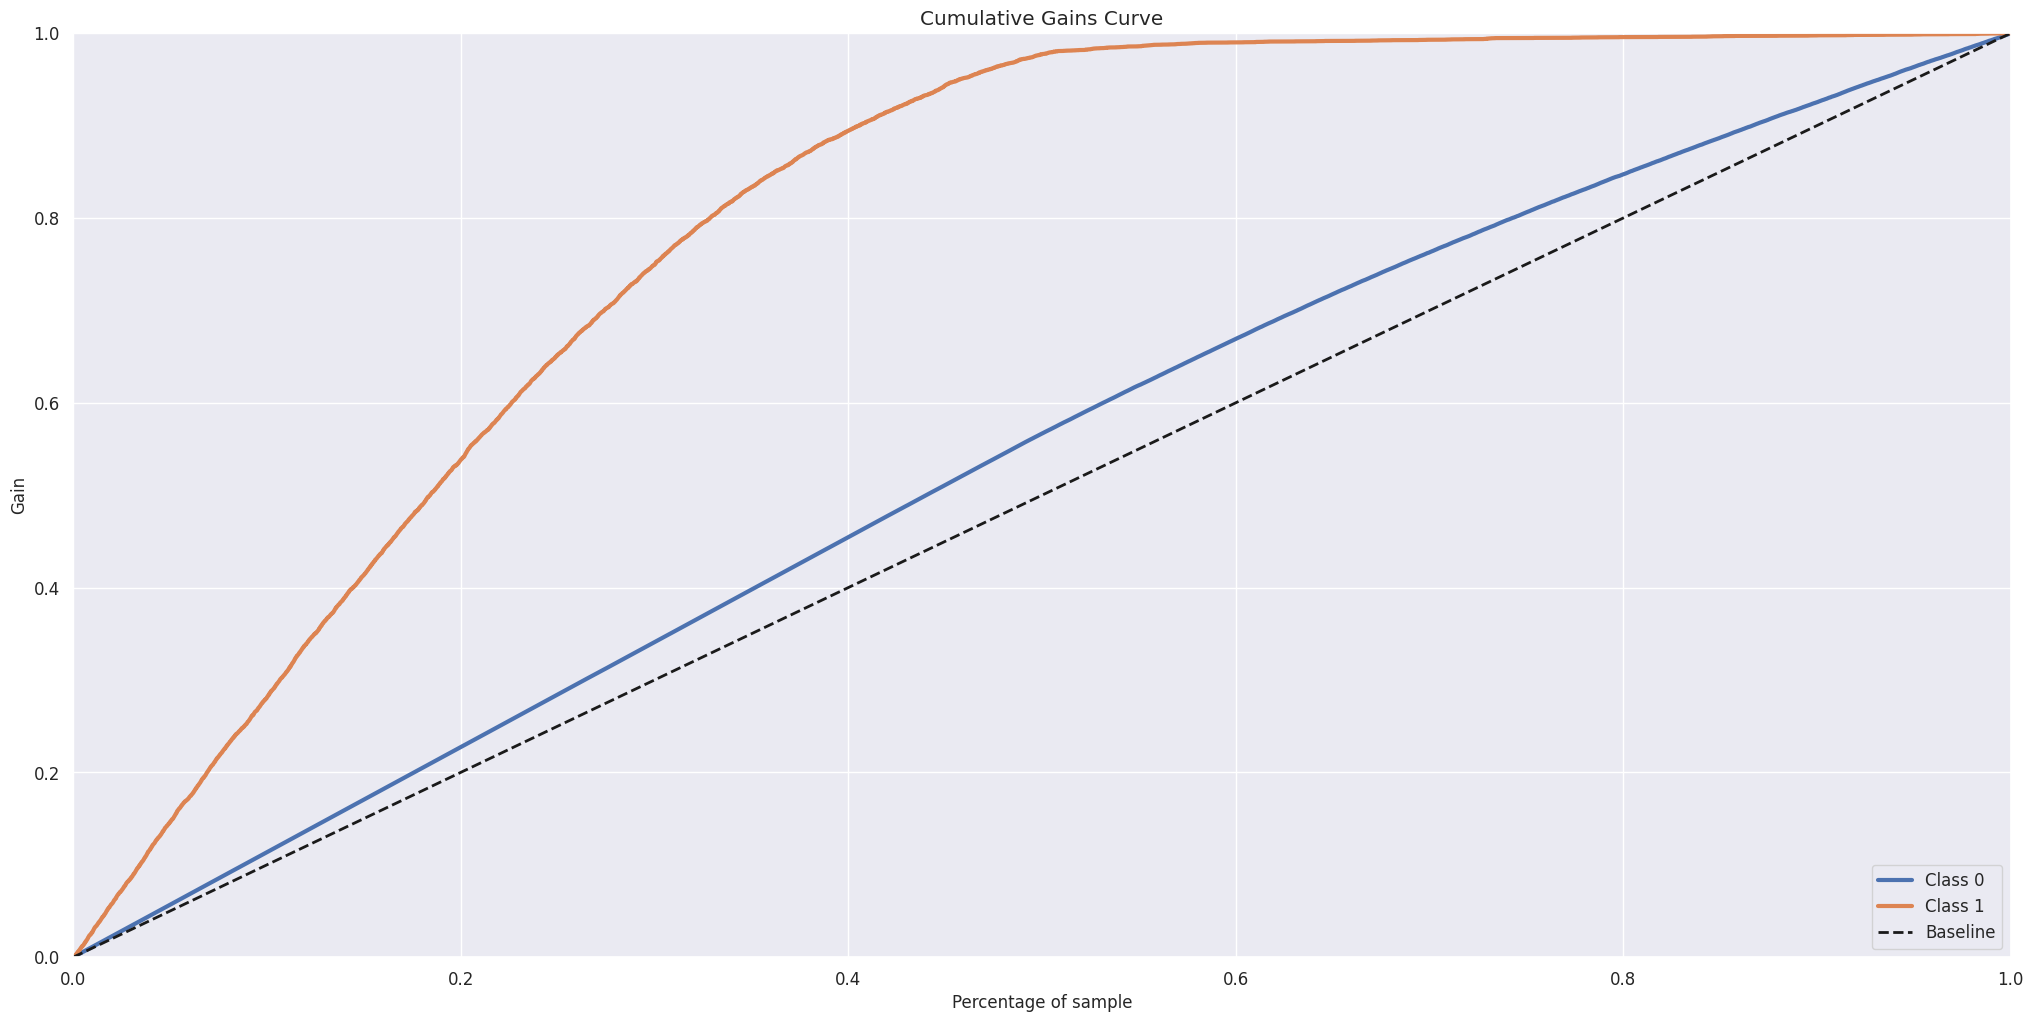

In [171]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr);

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

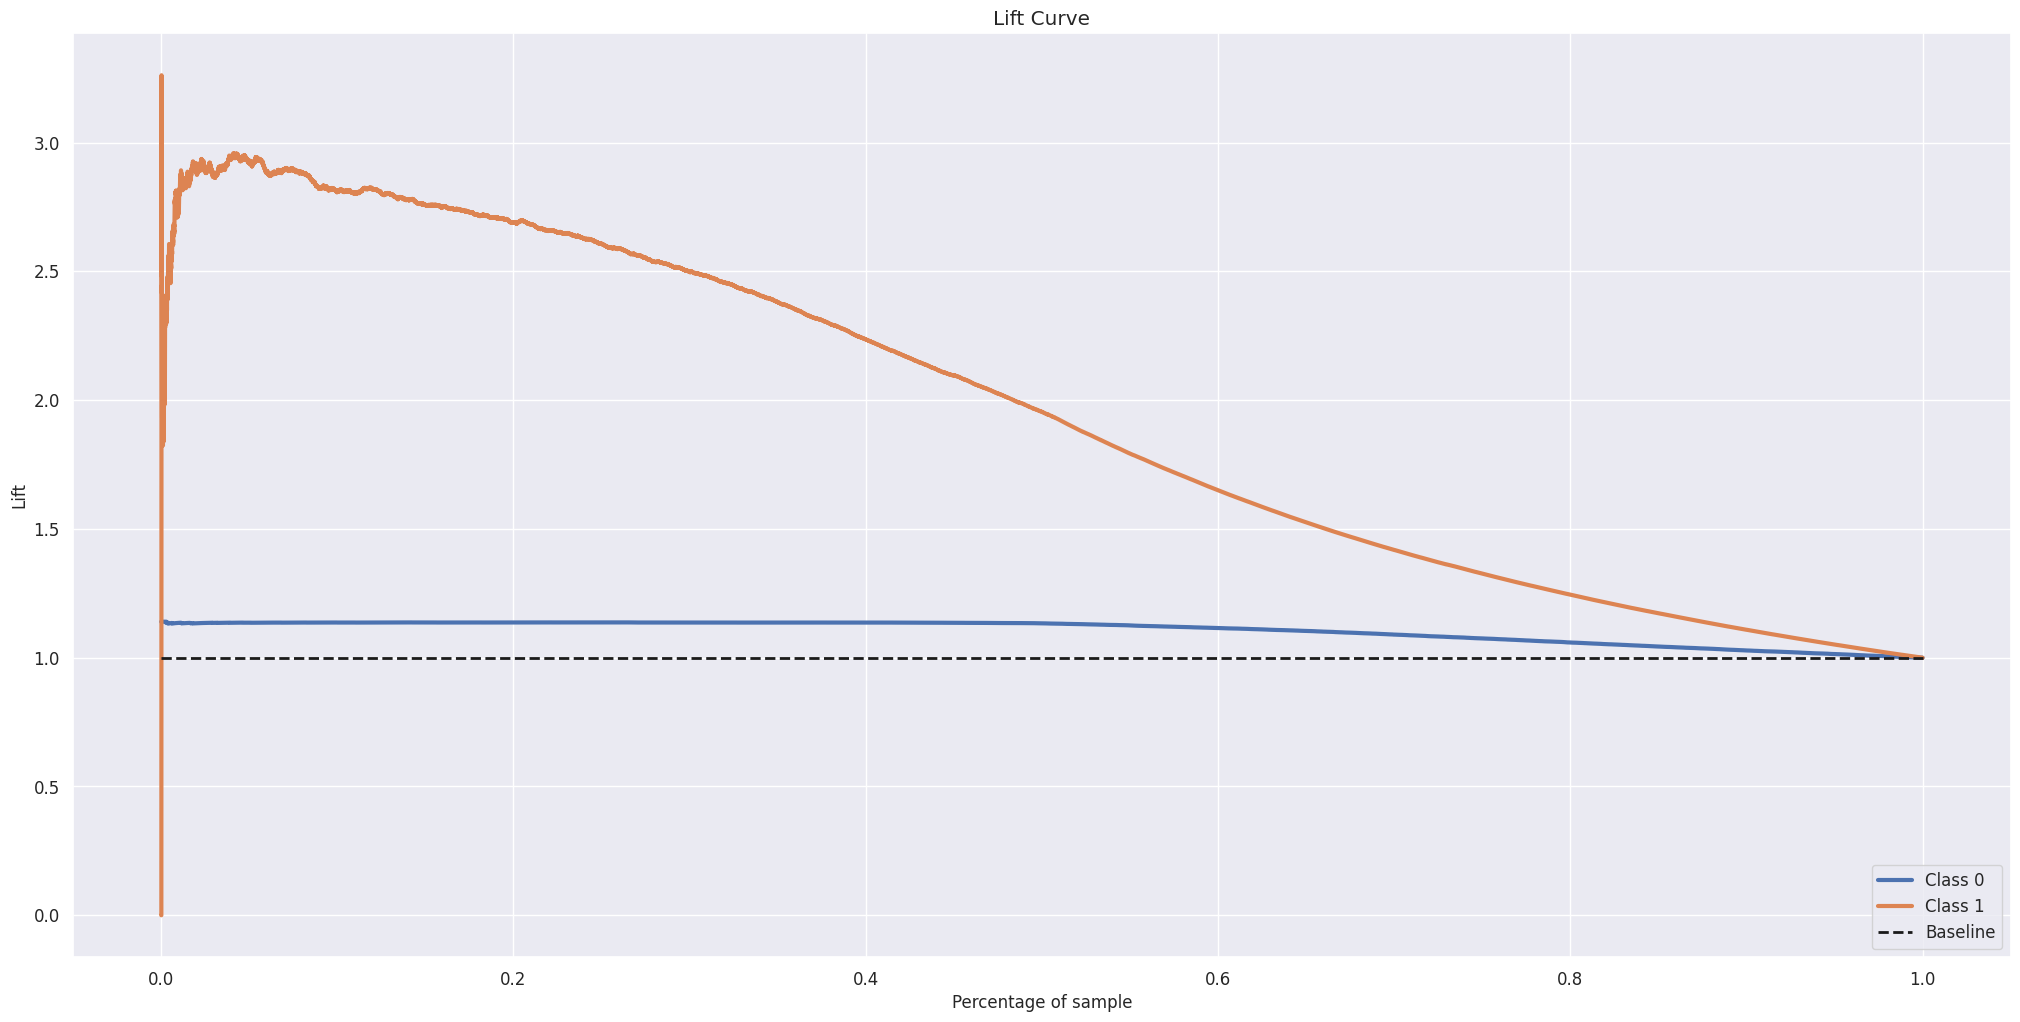

In [172]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lr)

In [173]:
lr_score = ml_top_k_scores('Linear Regression Model', y_validation, yhat_lr, 20000)
lr_score

,Precision_at_k,Recall_at_k,F1_at_k
Linear Regression Model,0.3168,0.6779,0.4318


In [174]:
lr_score_cv = ml_cv('Linear Regression Model', lr, x_train, y_train)
lr_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,Linear Regression Model,0.32 +/- 0.0016,0.68 +/- 0.0034,0.43 +/- 0.00218


## 6.4 XGBoost Classifier

In [175]:
%%time

#model Definition
model_xgb = xgb.XGBClassifier(objective= 'binary:logistic',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9,
                              random_state=32)

eval_set = [(x_validation, y_validation)]

#Model Training
model_xgb.fit( x_train,
              y_train,
              eval_set = eval_set,
              eval_metric = 'logloss',
              early_stopping_rounds=50,
              verbose=False)

#Model Predict
yhat_xgb = model_xgb.predict_proba( x_validation )
print(f"XGBoost logloss on the evaluation set: {log_loss(y_validation, yhat_xgb):.5f}")

[16:35:46] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

XGBoost logloss on the evaluation set: 0.38211
CPU times: user 2min 27s, sys: 305 ms, total: 2min 27s
Wall time: 1min 21s


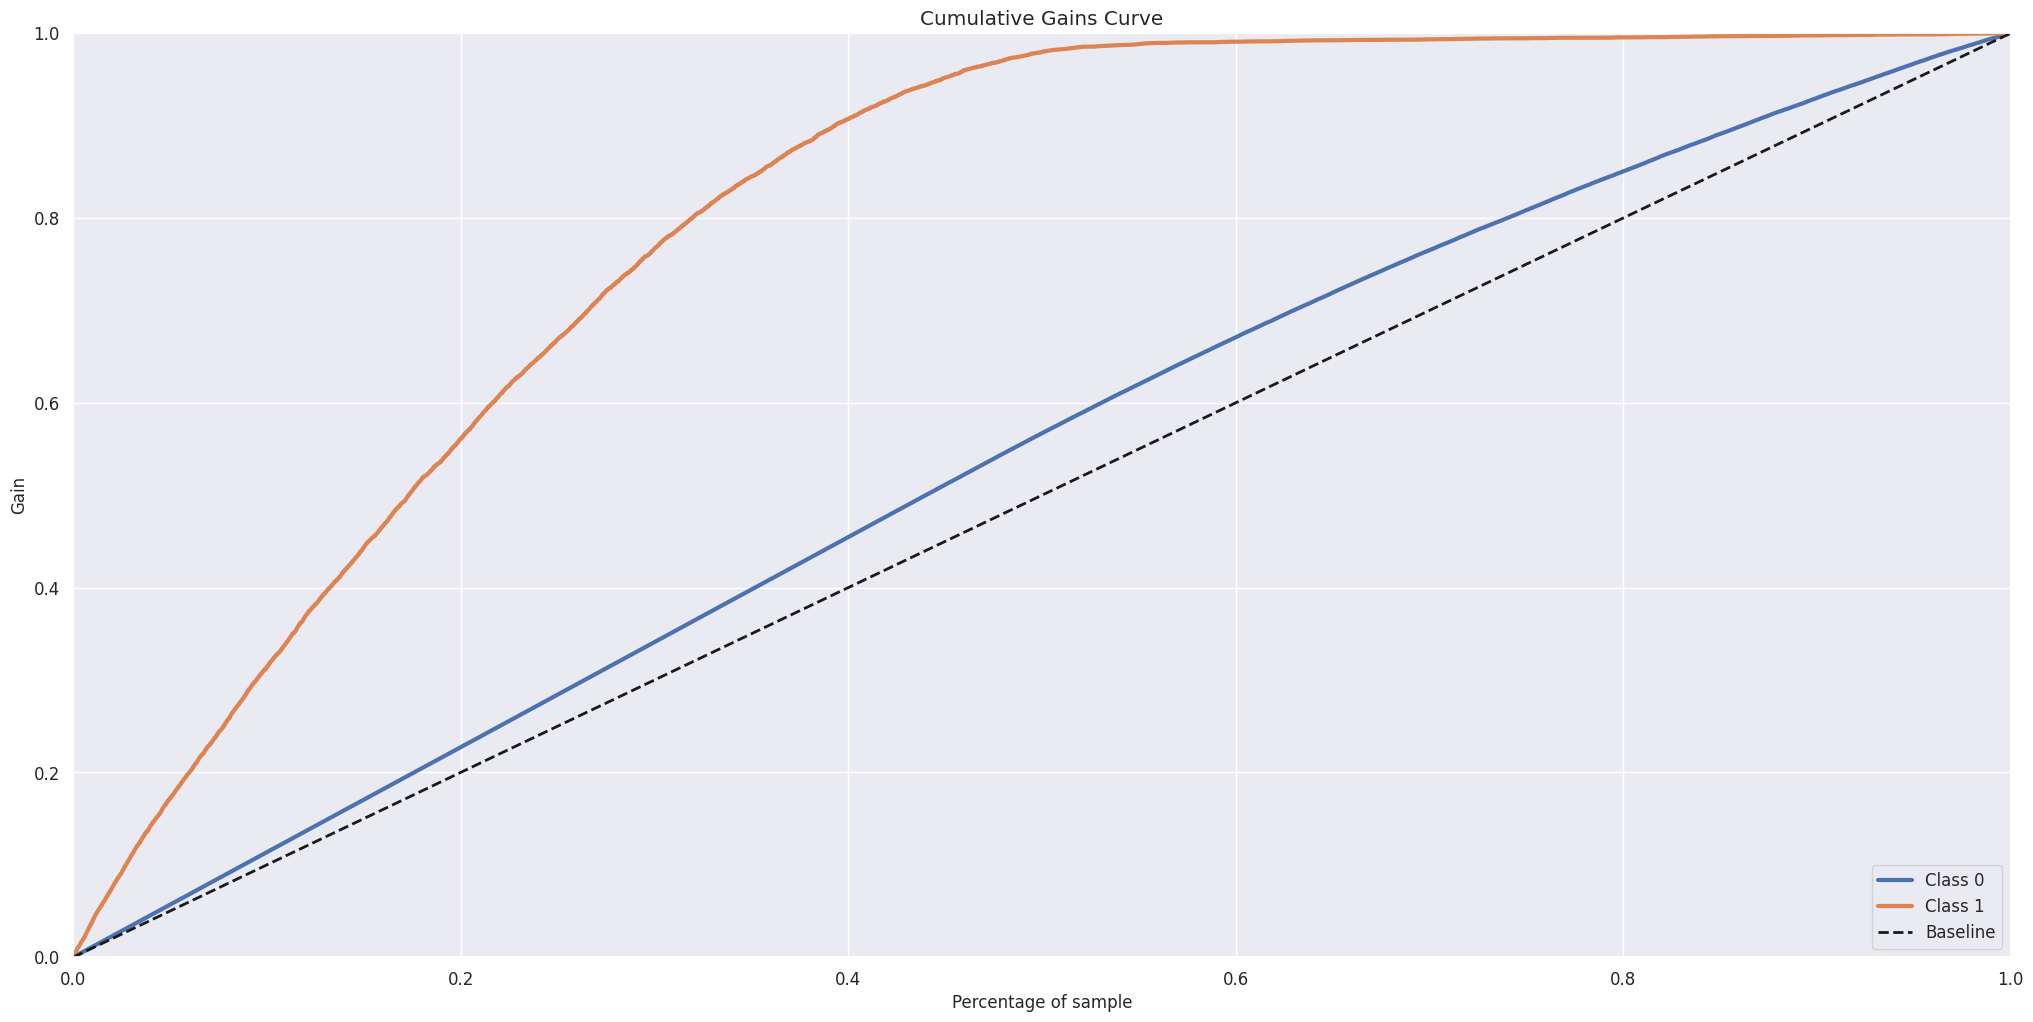

In [176]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_xgb);

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

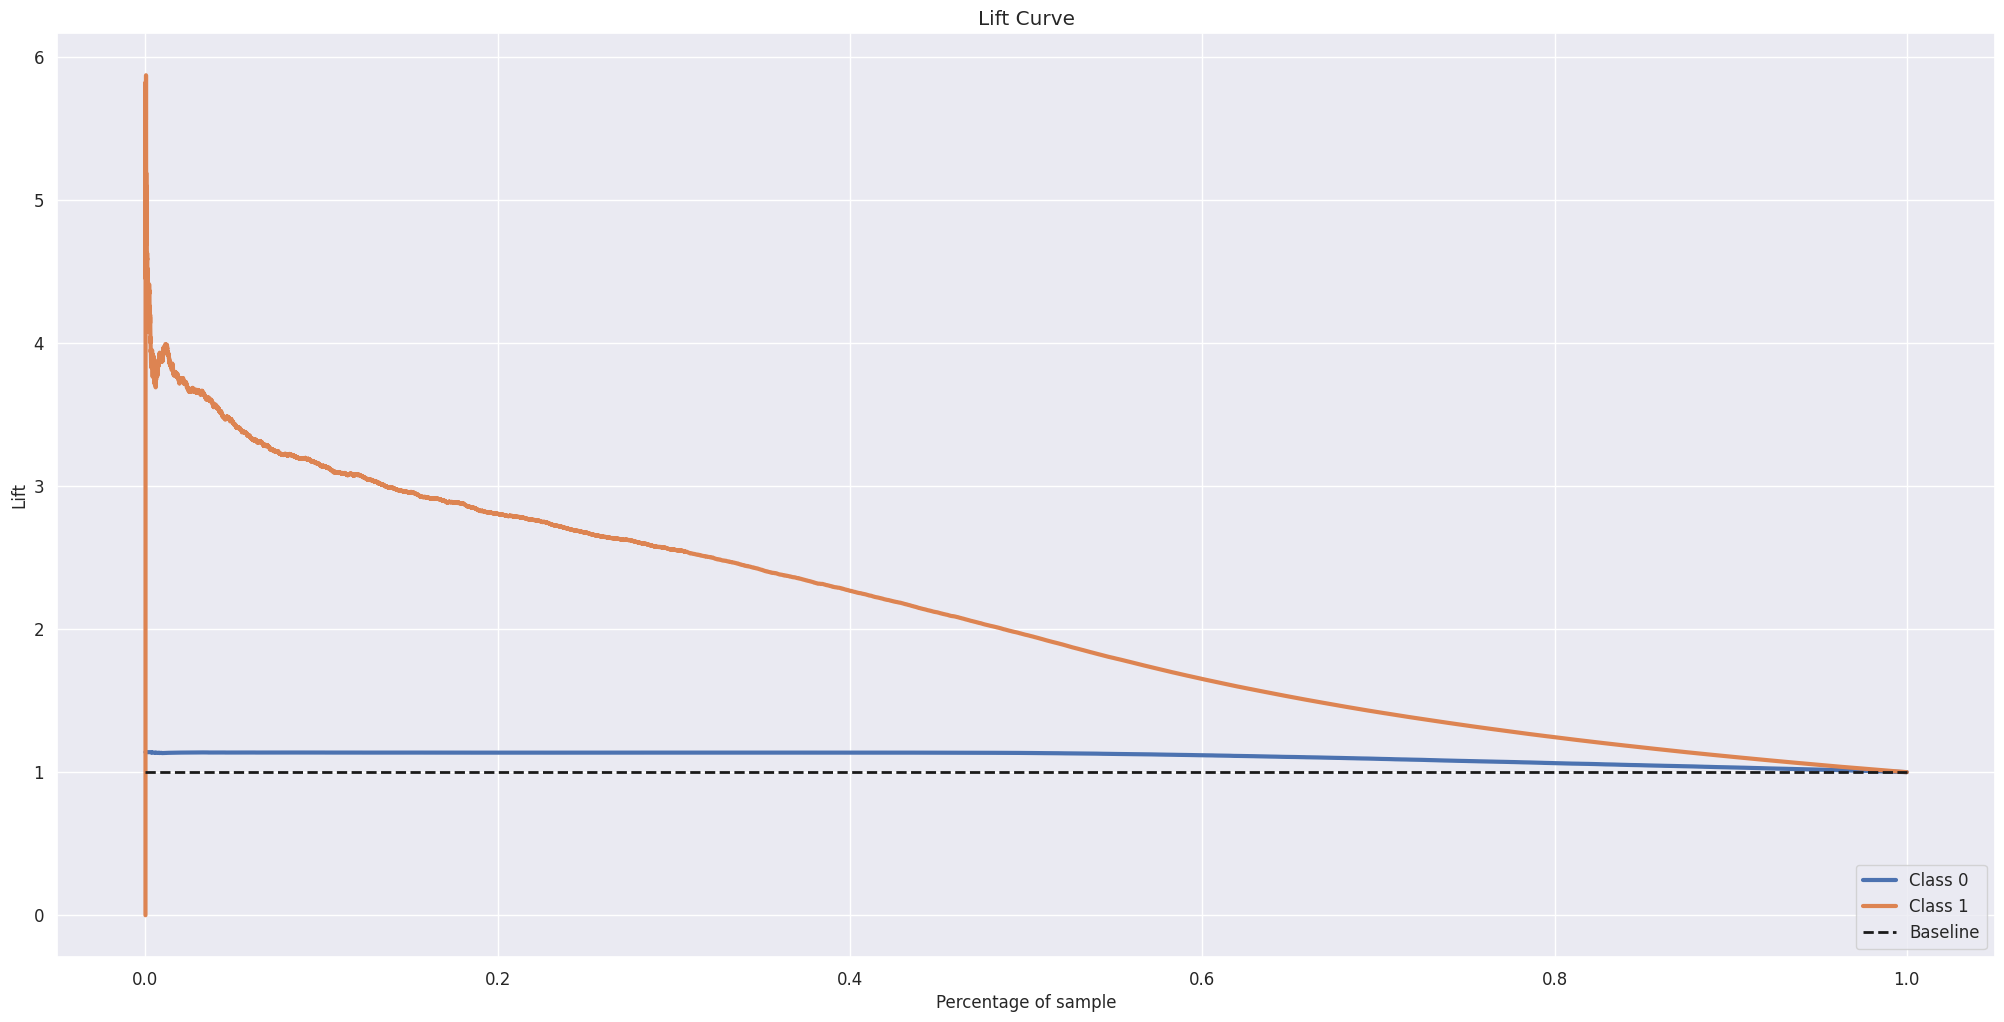

In [177]:
#Lift Gain Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb)

In [178]:
xgb_score = ml_top_k_scores('XGBoost Model', y_validation, yhat_xgb, 20000)
xgb_score

,Precision_at_k,Recall_at_k,F1_at_k
XGBoost Model,0.3238,0.6929,0.4414


In [179]:
xgb_score_cv = ml_cv('XGBoost Model', model_xgb, x_train, y_train)
xgb_score_cv

[16:37:10] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[16:38:08] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[16:39:07] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[16:40:03] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,Precision@k,Recall@k,F1_score@k
0,XGBoost Model,0.33 +/- 0.00266,0.7 +/- 0.00569,0.44 +/- 0.00363


## 6.5 LGBM Classifier

In [180]:
%%time

#Model Definition
model_lgbm = lgbm.LGBMClassifier(objective='binary',
                                n_estimators=100,
                                max_depth=10,
                                num_leaves = 700,
                                random_state=32
                               )

eval_set = [(x_validation, y_validation)]

#Model Training
model_lgbm.fit(x_train,
              y_train,
              eval_set = eval_set,
              early_stopping_rounds=50,
              eval_metric='binary_logloss',
              verbose=False)

#Model Predict
yhat_lgbm = model_lgbm.predict_proba( x_validation )
ylgbm_value = model_lgbm.predict( x_validation )
print(f"LGBM logloss on the evaluation set: {log_loss(y_validation, yhat_lgbm):.5f}")

LGBM logloss on the evaluation set: 0.27450
CPU times: user 14.1 s, sys: 107 ms, total: 14.2 s
Wall time: 8.2 s


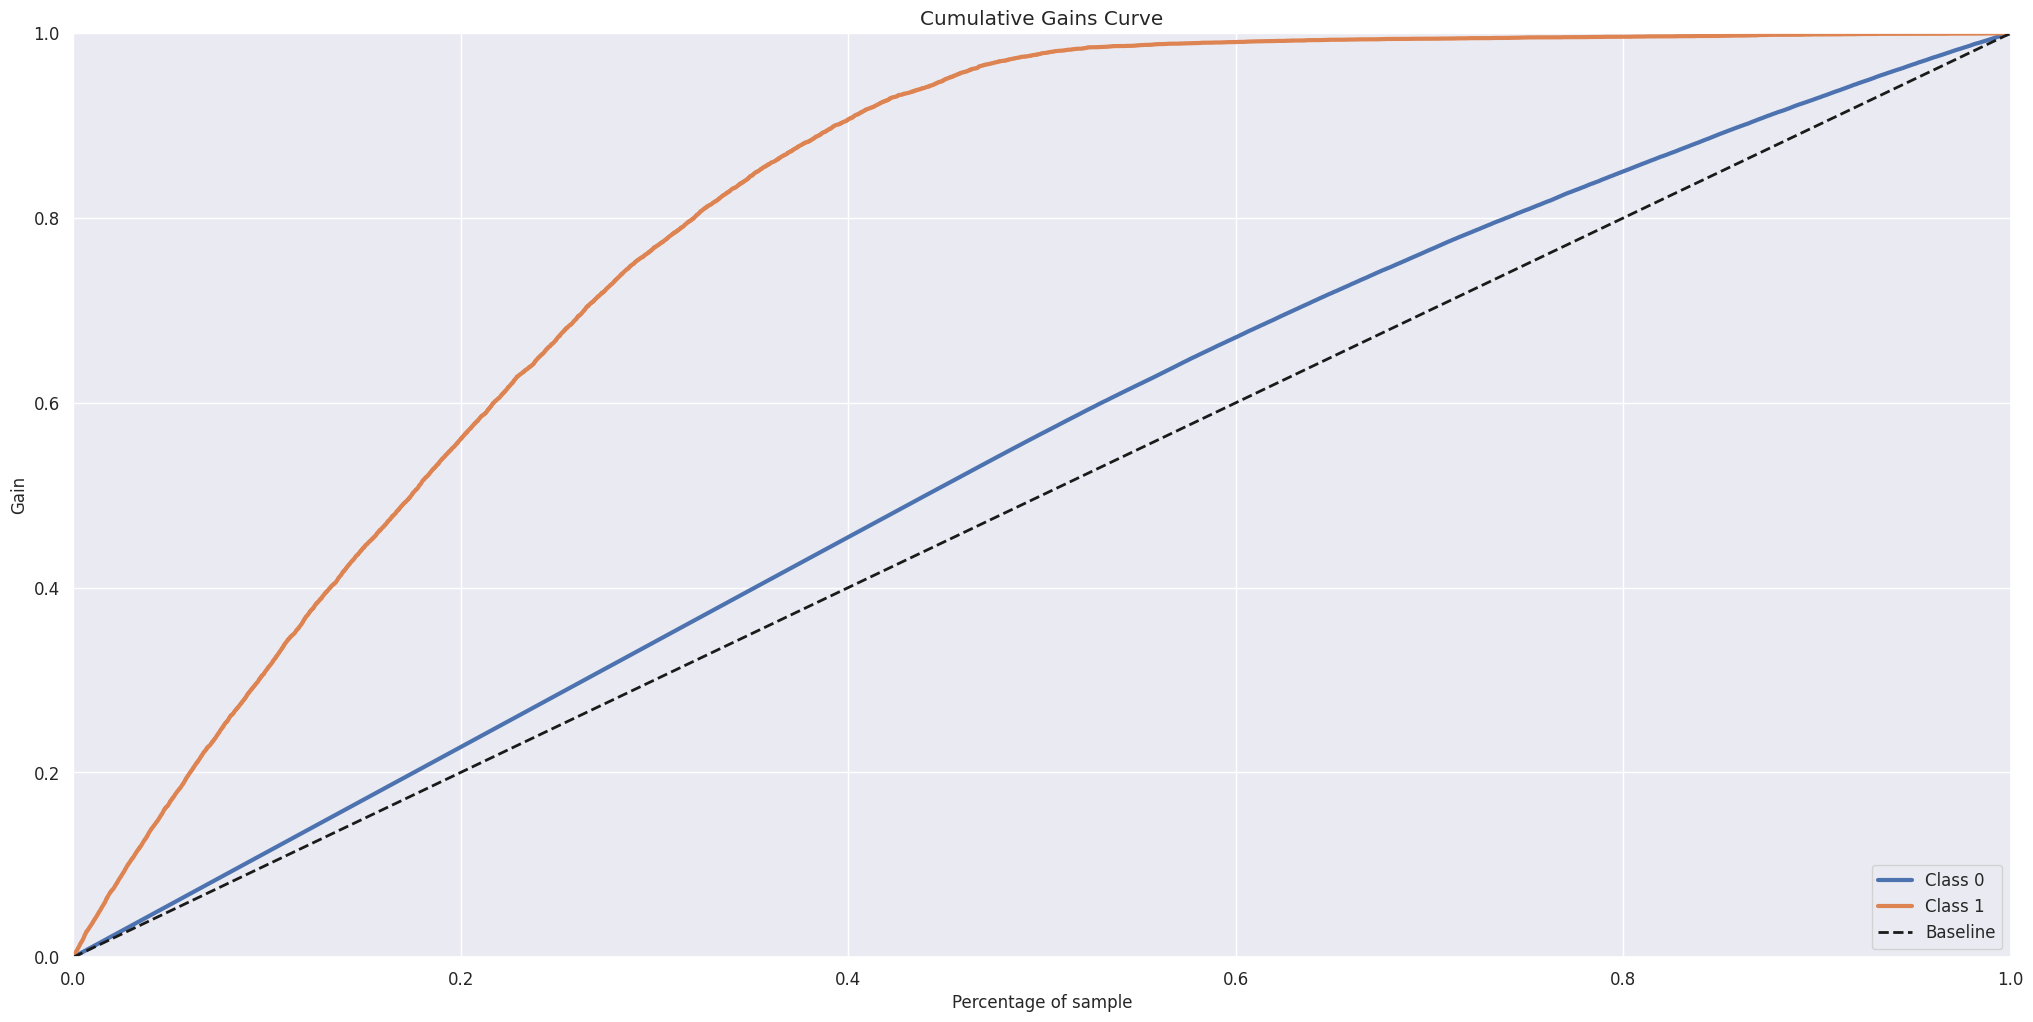

In [181]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm);

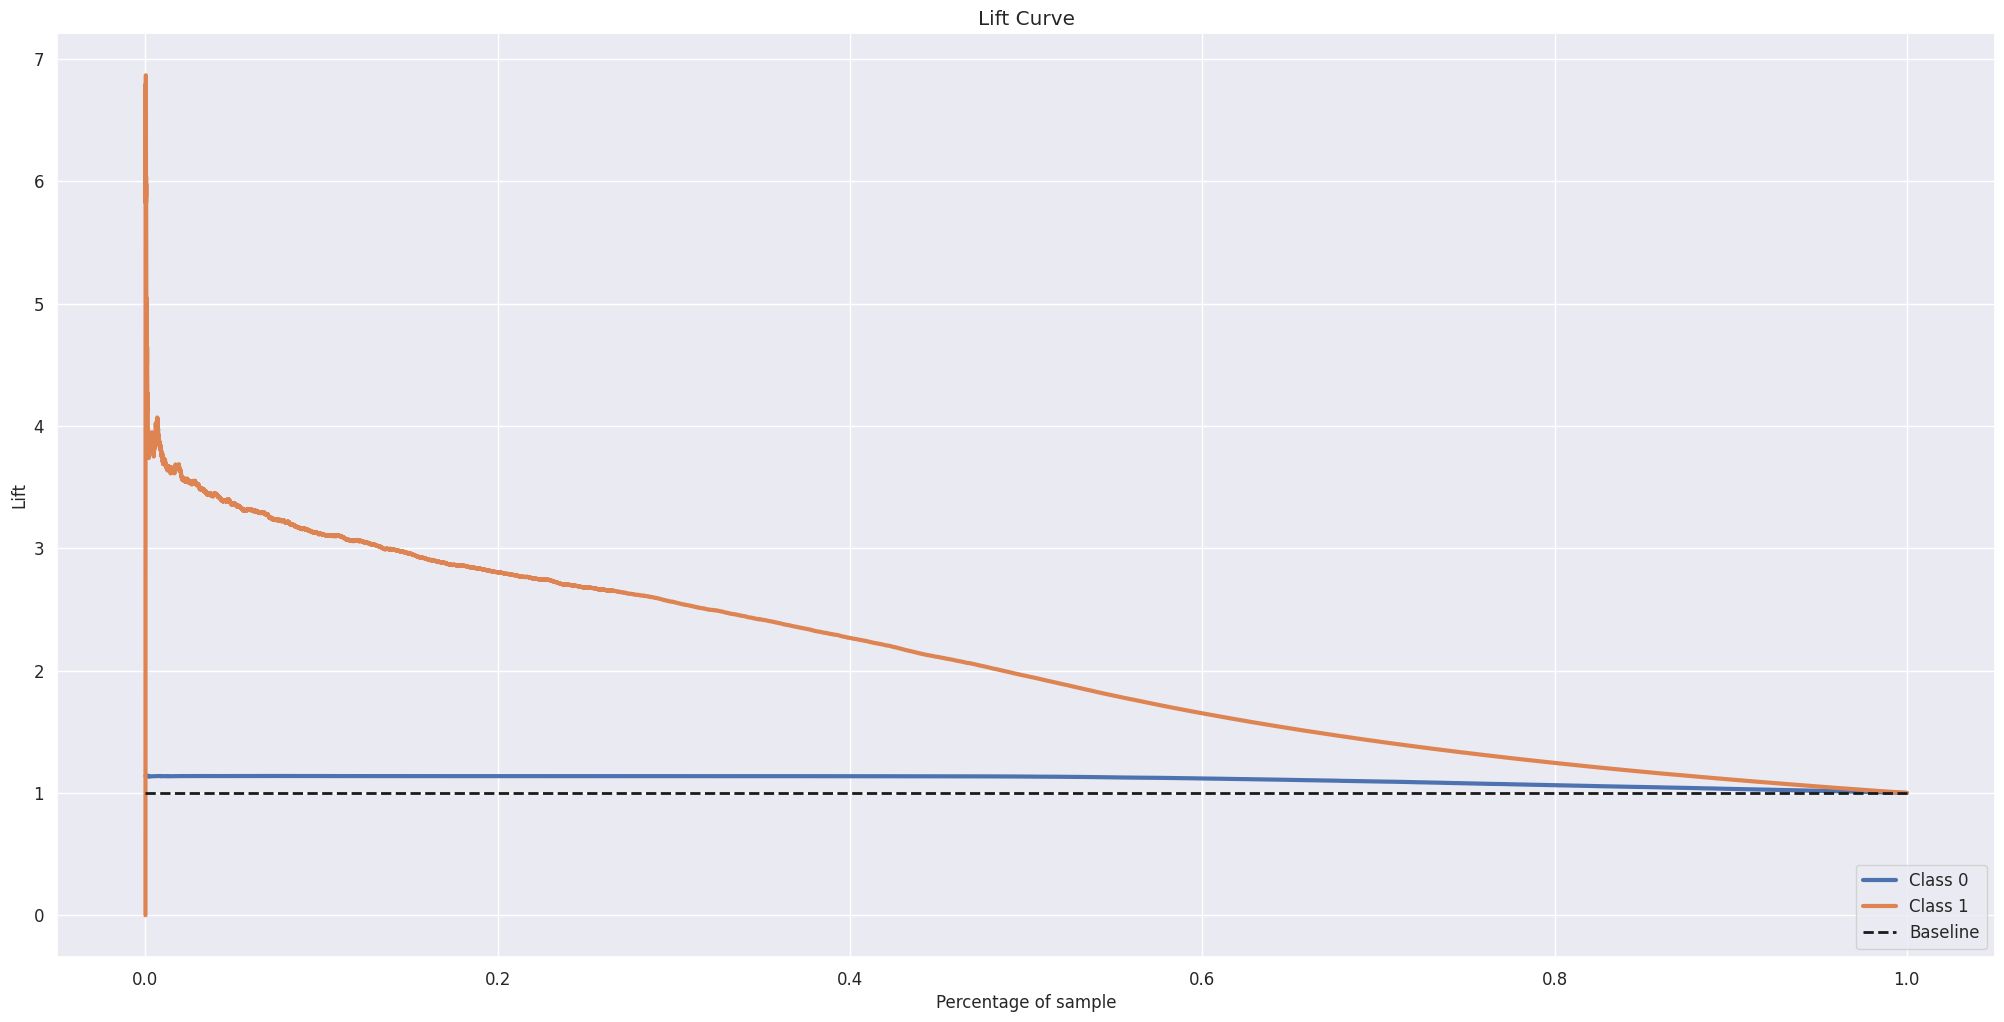

In [182]:
#Lift Gain Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm);

In [183]:
lgbm_score = ml_top_k_scores('LGBM Model', y_validation, yhat_lgbm, 20000)
lgbm_score

,Precision_at_k,Recall_at_k,F1_at_k
LGBM Model,0.3256,0.6966,0.4438


In [184]:
lgbm_score_cv = ml_cv('LGBM Model', model_lgbm, x_train, y_train)
lgbm_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,LGBM Model,0.32 +/- 0.00207,0.69 +/- 0.00442,0.44 +/- 0.00282


## 6.6 Performance Results Comparative



*   Validation Dataset



In [185]:
val_scores = pd.concat([dummy_score, knn_score, lr_score, xgb_score, lgbm_score])
val_scores

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1230,0.2633,0.1677
KNN Model,0.2878,0.6157,0.3922
Linear Regression Model,0.3168,0.6779,0.4318
XGBoost Model,0.3238,0.6929,0.4414
LGBM Model,0.3256,0.6966,0.4438




*   Cross Validation Dataset



In [186]:
cv_scores = pd.concat([dummy_score_cv, knn_score_cv, lr_score_cv, xgb_score_cv, lgbm_score_cv])
cv_scores

,Model Name,Precision@k,Recall@k,F1_score@k
0,Dummy Model,0.12 +/- 0.00127,0.27 +/- 0.00271,0.17 +/- 0.00173
0,KNN Model,0.29 +/- 0.00118,0.61 +/- 0.00254,0.39 +/- 0.00161
0,Linear Regression Model,0.32 +/- 0.0016,0.68 +/- 0.0034,0.43 +/- 0.00218
0,XGBoost Model,0.33 +/- 0.00266,0.7 +/- 0.00569,0.44 +/- 0.00363
0,LGBM Model,0.32 +/- 0.00207,0.69 +/- 0.00442,0.44 +/- 0.00282




*   Given the Results, the Machine Learning model chosen for hyperparameter fine tunning and deploy is LGBM Model, due to having very similar to the model that obtained the best results (XGBoost), but with faster runtime.



# 7.0 HYPERPARAMETER FINE TUNNING

In [84]:
#param = { 'n_estimators': [50, 100, 150],
#          'eta':[0.01, 0.03],
#          'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#          'colsample_bytee': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 8, 15]}
#
#MAX_EVAL = 5

In [85]:
#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    #model
#    model_xgb = xgb.XGBRegressor (objective = 'reg:squarederror',
#                                  n_estimators= hp['n_estimators'],
#                                  eta= hp['eta'],
#                                  max_depth= hp['max_depth'],
#                                  subsample= hp['subsample'],
#                                  colsample_bytee= hp['colsample_bytee'],
#                                  min_child_weight= hp['min_child_weight']).fit(x_train, y_train)
#
    #performance
#    result = cross_validation(x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result

In [105]:
#Optuna Tunning
study = optuna.create_study(direction='maximize', study_name='LGBM Classifier')
function = lambda trial: objective(trial, x_train, y_train, 20000)
study.optimize(function, n_trials=100)

[I 2023-07-18 16:07:22,992] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:08:13,775] Trial 0 finished with value: 0.5076140433979038 and parameters: {'boosting': 'dart', 'n_estimators': 200, 'learning_rate': 0.29191795137491255, 'max_depth': 13, 'num_leaves': 688, 'min_data_in_leaf': 2400, 'min_gain_to_split': 5, 'lambda_l1': 70, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.5076140433979038.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0

[I 2023-07-18 16:08:22,985] Trial 1 finished with value: 0.5516573586893122 and parameters: {'boosting': 'gbdt', 'n_estimators': 50, 'learning_rate': 0.03363124342522751, 'max_depth': 3, 'num_leaves': 788, 'min_data_in_leaf': 1800, 'min_gain_to_split': 10, 'lambda_l1': 30, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.5516573586893122.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:08:58,540] Trial 2 finished with value: 0.5540768548801515 and parameters: {'boosting': 'dart', 'n_estimators': 100, 'learning_rate': 0.19950735539563302, 'max_depth': 5, 'num_leaves': 388, 'min_data_in_leaf': 3200, 'min_gain_to_split': 5, 'lambda_l1': 40, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 2 with value: 0.5540768548801515.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0

[I 2023-07-18 16:10:40,907] Trial 3 finished with value: 0.539345435499268 and parameters: {'boosting': 'dart', 'n_estimators': 300, 'learning_rate': 0.03416456852435587, 'max_depth': 9, 'num_leaves': 728, 'min_data_in_leaf': 3200, 'min_gain_to_split': 5, 'lambda_l1': 90, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 0.5540768548801515.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:11:03,415] Trial 4 finished with value: 0.5521497264988378 and parameters: {'boosting': 'gbdt', 'n_estimators': 150, 'learning_rate': 0.061283640262990234, 'max_depth': 3, 'num_leaves': 788, 'min_data_in_leaf': 7200, 'min_gain_to_split': 5, 'lambda_l1': 80, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 2 with value: 0.5540768548801515.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5


[I 2023-07-18 16:11:03,987] Trial 5 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:11:53,464] Trial 6 finished with value: 0.6997547735512545 and parameters: {'boosting': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.017060612672094237, 'max_depth': 15, 'num_leaves': 228, 'min_data_in_leaf': 700, 'min_gain_to_split': 5, 'lambda_l1': 40, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10


[I 2023-07-18 16:11:53,995] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:11:54,525] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:11:55,072] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:11:55,716] Trial 10 pruned. Trial was pruned at iteration 2.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:12:29,830] Trial 11 finished with value: 0.5571435406716726 and parameters: {'boosting': 'gbdt', 'n_estimators': 150, 'learning_rate': 0.09097969365996791, 'max_depth': 7, 'num_leaves': 248, 'min_data_in_leaf': 200, 'min_gain_to_split': 0, 'lambda_l1': 40, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004,

[I 2023-07-18 16:13:11,366] Trial 12 finished with value: 0.5566510238563709 and parameters: {'boosting': 'gbdt', 'n_estimators': 200, 'learning_rate': 0.09329811730324088, 'max_depth': 7, 'num_leaves': 268, 'min_data_in_leaf': 100, 'min_gain_to_split': 0, 'lambda_l1': 40, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:13:12,094] Trial 13 pruned. Trial was pruned at iteration 2.
[I 2023-07-18 16:13:12,826] Trial 14 pruned. Trial was pruned at iteration 2.
[I 2023-07-18 16:13:13,517] Trial 15 pruned. Trial was pruned at iteration 2.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:13:46,702] Trial 16 finished with value: 0.55585920705458 and parameters: {'boosting': 'gbdt', 'n_estimators': 150, 'learning_rate': 0.051000737273960095, 'max_depth': 13, 'num_leaves': 948, 'min_data_in_leaf': 1200, 'min_gain_to_split': 0, 'lambda_l1': 30, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15


[I 2023-07-18 16:13:47,291] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:13:47,970] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:13:48,619] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:13:49,552] Trial 20 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004,

[I 2023-07-18 16:14:32,656] Trial 21 finished with value: 0.5564664390957921 and parameters: {'boosting': 'gbdt', 'n_estimators': 200, 'learning_rate': 0.0899792943944325, 'max_depth': 7, 'num_leaves': 248, 'min_data_in_leaf': 200, 'min_gain_to_split': 0, 'lambda_l1': 40, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:14:33,301] Trial 22 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:14:57,195] Trial 23 finished with value: 0.5550403904158513 and parameters: {'boosting': 'gbdt', 'n_estimators': 150, 'learning_rate': 0.06437617759003156, 'max_depth': 9, 'num_leaves': 168, 'min_data_in_leaf': 1200, 'min_gain_to_split': 5, 'lambda_l1': 20, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:14:57,819] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:14:58,496] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:14:59,108] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:14:59,845] Trial 27 pruned. Trial was pruned at iteration 4.
[I 2023-07-18 16:15:00,518] Trial 28 pruned. Trial was pruned at iteration 1.
[I 2023-07-18 16:15:01,117] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:15:01,713] Trial 30 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004,

[I 2023-07-18 16:15:42,285] Trial 31 finished with value: 0.5566034357913194 and parameters: {'boosting': 'gbdt', 'n_estimators': 200, 'learning_rate': 0.09665146562366406, 'max_depth': 7, 'num_leaves': 228, 'min_data_in_leaf': 100, 'min_gain_to_split': 0, 'lambda_l1': 40, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:15:43,041] Trial 32 pruned. Trial was pruned at iteration 4.
[I 2023-07-18 16:15:43,789] Trial 33 pruned. Trial was pruned at iteration 4.
[I 2023-07-18 16:15:44,372] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:15:45,811] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:15:46,972] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:15:47,993] Trial 37 pruned. Trial was pruned at iteration 3.
[I 2023-07-18 16:15:48,793] Trial 38 pruned. Trial was pruned at iteration 3.
[I 2023-07-18 16:15:49,418] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:15:50,035] Trial 40 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004,

[I 2023-07-18 16:16:31,280] Trial 41 finished with value: 0.556346467306958 and parameters: {'boosting': 'gbdt', 'n_estimators': 200, 'learning_rate': 0.09097165255804432, 'max_depth': 7, 'num_leaves': 228, 'min_data_in_leaf': 100, 'min_gain_to_split': 0, 'lambda_l1': 40, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:16:31,891] Trial 42 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:16:32,597] Trial 43 pruned. Trial was pruned at iteration 1.
[I 2023-07-18 16:16:33,258] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:16:33,926] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:16:34,766] Trial 46 pruned. Trial was pruned at iteration 5.
[I 2023-07-18 16:16:36,162] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:16:37,545] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:16:38,242] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:16:38,854] Trial 50 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004,

[I 2023-07-18 16:17:20,546] Trial 51 finished with value: 0.5565392028398153 and parameters: {'boosting': 'gbdt', 'n_estimators': 200, 'learning_rate': 0.09117261088086992, 'max_depth': 7, 'num_leaves': 248, 'min_data_in_leaf': 100, 'min_gain_to_split': 0, 'lambda_l1': 40, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:17:21,163] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:21,781] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:22,484] Trial 54 pruned. Trial was pruned at iteration 2.
[I 2023-07-18 16:17:23,209] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:23,895] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:24,537] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:25,140] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:25,764] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:27,213] Trial 60 pruned. Trial was pruned at iteration 1.
[I 2023-07-18 16:17:28,961] Trial 61 pruned. Trial was pruned at iteration 9.
[I 2023-07-18 16:17:29,758] Trial 62 pruned. Trial was pruned at iteration 4.
[I 2023-07-18 16:17:30,432] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2023-07-18 16:17:31,163] Trial 64 pruned. Trial was pruned at

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:18:19,321] Trial 74 finished with value: 0.5576097910022921 and parameters: {'boosting': 'gbdt', 'n_estimators': 150, 'learning_rate': 0.05651779917467524, 'max_depth': 15, 'num_leaves': 768, 'min_data_in_leaf': 400, 'min_gain_to_split': 0, 'lambda_l1': 20, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:18:40,884] Trial 75 finished with value: 0.5591300785971944 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.0613179925739269, 'max_depth': 15, 'num_leaves': 848, 'min_data_in_leaf': 300, 'min_gain_to_split': 0, 'lambda_l1': 20, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:19:02,970] Trial 76 finished with value: 0.557845373719181 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.06062578154478675, 'max_depth': 15, 'num_leaves': 848, 'min_data_in_leaf': 1800, 'min_gain_to_split': 0, 'lambda_l1': 20, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:19:03,632] Trial 77 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:19:25,915] Trial 78 finished with value: 0.5571601580493668 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.060498484207890266, 'max_depth': 15, 'num_leaves': 908, 'min_data_in_leaf': 800, 'min_gain_to_split': 0, 'lambda_l1': 20, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:19:27,928] Trial 79 pruned. Trial was pruned at iteration 26.
[I 2023-07-18 16:19:28,677] Trial 80 pruned. Trial was pruned at iteration 4.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:20:11,532] Trial 81 finished with value: 0.557995275822386 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.06447970939321879, 'max_depth': 15, 'num_leaves': 828, 'min_data_in_leaf': 900, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:20:34,462] Trial 82 finished with value: 0.5582307920597745 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.0649511840215338, 'max_depth': 15, 'num_leaves': 808, 'min_data_in_leaf': 900, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: b

[I 2023-07-18 16:20:58,512] Trial 83 finished with value: 0.5575242020844706 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.06364625258990629, 'max_depth': 15, 'num_leaves': 828, 'min_data_in_leaf': 900, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:21:21,976] Trial 84 finished with value: 0.5570102719929374 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.06287932325956293, 'max_depth': 15, 'num_leaves': 808, 'min_data_in_leaf': 1900, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:21:22,965] Trial 85 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:21:46,681] Trial 86 finished with value: 0.5578025402895287 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.05718256511154339, 'max_depth': 13, 'num_leaves': 828, 'min_data_in_leaf': 1300, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:22:10,671] Trial 87 finished with value: 0.5566891507909515 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.05710558719567543, 'max_depth': 13, 'num_leaves': 828, 'min_data_in_leaf': 2200, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:22:12,593] Trial 88 pruned. Trial was pruned at iteration 34.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:22:36,075] Trial 89 finished with value: 0.5579095952087021 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.06552780950444295, 'max_depth': 15, 'num_leaves': 748, 'min_data_in_leaf': 1700, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5


[I 2023-07-18 16:22:36,703] Trial 90 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:22:59,545] Trial 91 finished with value: 0.5575027865158427 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.060476482059570034, 'max_depth': 15, 'num_leaves': 788, 'min_data_in_leaf': 1700, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:23:22,550] Trial 92 finished with value: 0.5570531421009346 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.07089320206456409, 'max_depth': 15, 'num_leaves': 668, 'min_data_in_leaf': 1800, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:23:23,952] Trial 93 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, 

[I 2023-07-18 16:23:47,341] Trial 94 finished with value: 0.5575241539441429 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.04938688674635459, 'max_depth': 15, 'num_leaves': 788, 'min_data_in_leaf': 1600, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


[I 2023-07-18 16:23:49,741] Trial 95 pruned. Trial was pruned at iteration 51.
[I 2023-07-18 16:23:50,580] Trial 96 pruned. Trial was pruned at iteration 6.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value:

[I 2023-07-18 16:24:14,783] Trial 97 finished with value: 0.5581237233862218 and parameters: {'boosting': 'gbdt', 'n_estimators': 100, 'learning_rate': 0.05190041197246242, 'max_depth': 13, 'num_leaves': 868, 'min_data_in_leaf': 1100, 'min_gain_to_split': 0, 'lambda_l1': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.6997547735512545.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10


[I 2023-07-18 16:24:15,554] Trial 98 pruned. Trial was pruned at iteration 4.
[I 2023-07-18 16:24:16,650] Trial 99 pruned. Trial was pruned at iteration 16.


In [87]:
print(f"\tBest value (Recall_at_K): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (Recall_at_K): 0.73794
	Best params:
		boosting: dart
		n_estimators: 200
		learning_rate: 0.19504075923504913
		max_depth: 11
		num_leaves: 568
		min_data_in_leaf: 400
		min_gain_to_split: 5
		lambda_l1: 10
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.8


# 8.0 PERFORMANCE METRICS

In [96]:
%%time

#Model Definition
model_lgbm = lgbm.LGBMClassifier(boosting='dart',
                                 objective='binary',
                                 n_estimators=200,
                                 learning_rate= 0.19504075923504913,
                                 max_depth= 11,
                                 num_leaves = 568,
                                 min_data_in_leaf= 400,
                                 min_gain_to_split= 5,
                                 lambda_l1= 10,
                                 bagging_fraction=0.8,
                                 bagging_freq=1,
                                 feature_fraction=0.8,
                                 random_state=32
                               )

eval_set = [(x_validation, y_validation)]

#Model Training
model_lgbm.fit(x_train,
              y_train,
              eval_set = eval_set,
              early_stopping_rounds=50,
              eval_metric='auc',
              verbose=False)

#Model Predict
yhat_lgbm = model_lgbm.predict_proba( x_validation )

[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
CPU times: user 1min 9s, sys: 105 ms, total: 1min 9s
Wall time: 39.4 s


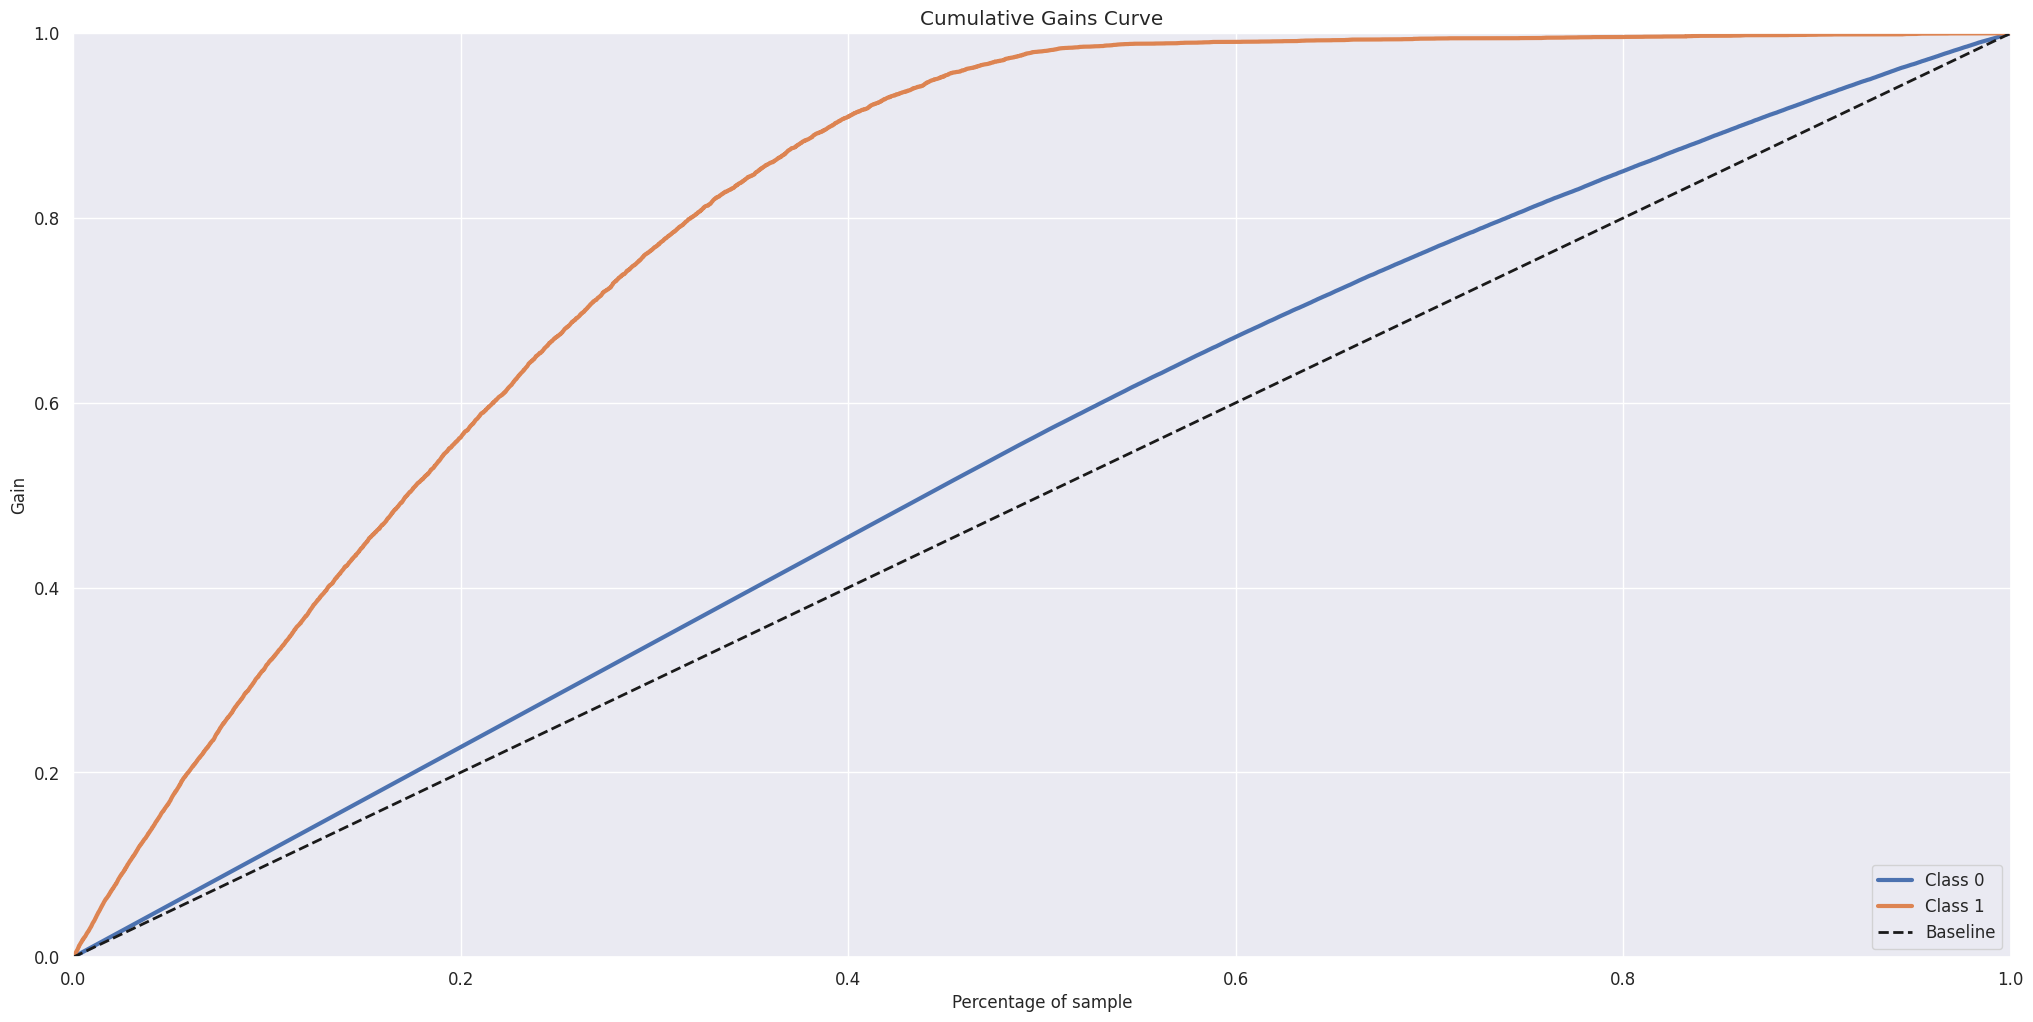

In [97]:
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm);

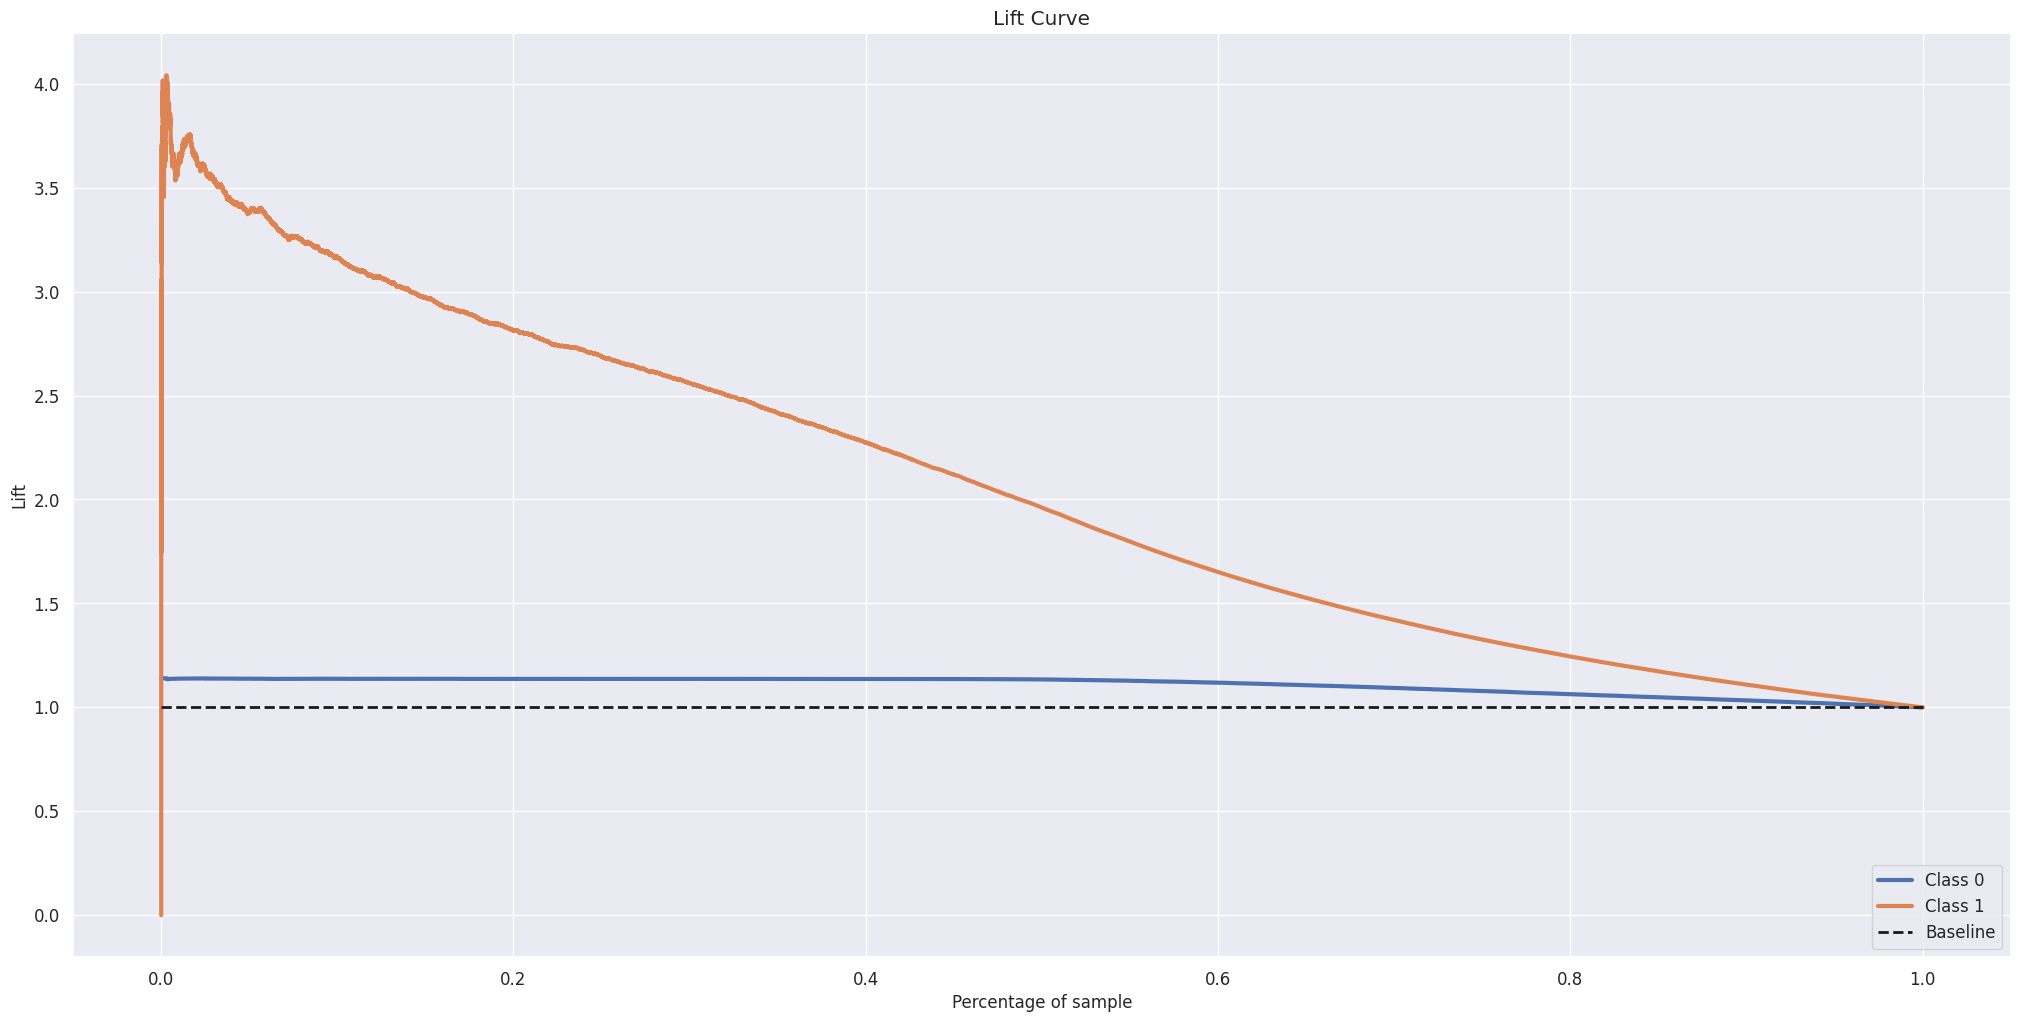

In [98]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm);

In [99]:
results = pd.DataFrame({ ''})

k = 20000
print('Precision@k: {:.2f}, Recall@k: {:.2f} for k={}'.format(top_k_precision(y_validation, yhat_lgbm, k),
                                                              top_k_recall(y_validation, yhat_lgbm, k),k))

Precision@k: 0.33, Recall@k: 0.70 for k=20000


In [100]:
ml_top_k_scores('LGBM Model', y_validation, yhat_lgbm, 20000)

,Precision_at_k,Recall_at_k,F1_at_k
LGBM Model,0.3256,0.6967,0.4438


In [101]:
ml_cv('LGBM Model', model_lgbm, x_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: b

,Model Name,Precision@k,Recall@k,F1_score@k
0,LGBM Model,0.33 +/- 0.00334,0.7 +/- 0.00714,0.44 +/- 0.00455


In [102]:
y_validation.shape

(76222,)

In [103]:
304887/4

76221.75